#  627 PROJECT
## Group 3｜Nov 2023

## 00 Import

In [4]:
import numpy as np
import pandas as pd


# Plot
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import plotly.graph_objs as go


# Import data
from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

(
    yf
    .pdr_override()
)
import time
import re


# Import xlrd ####
import warnings
warnings.filterwarnings("ignore")

# Random Number
import random

# Optimize
from skopt import gp_minimize
from functools import partial


# Let's set some print option.

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

In [5]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor

# for data split
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf

In [6]:
spy = yf.download('SPY', "2004-11-01", "2023-11-01")

[*********************100%%**********************]  1 of 1 completed


# 👉 <a id = "top">CONTEXT</a> 👈 

# [PART1 STRATEGY](#part1)
## [1. Build Strategy](#p1)
### [1.1 Momentum Strategy](#p1.1)
#### [1.1.1 Simple Moving Average](#p1.1.1)
#### [1.1.2 Exponential Moving Average](#p1.1.2)
### [1.2 Mean Reversion](#p1.2)
#### [1.2.1 Relative Strength Index (RSI)](#p1.2.1)
#### [1.2.2 Moving Average Convergence Divergence (MACD)](#p1.2.2)
#### [1.2.3 Bollinger Bands](#p1.2.3)
#### [1.2.4 Stochastic Oscillator](#p1.2.4)
#### [1.2.5 Commodity Channel Index](#p1.2.5)
#### [1.2.6 Momentum Indicator Crossover Strategy](#p1.2.6)
### [1.3 Machine Learning](#p1.3)
### [1.4 Combined Strategy](#p1.4)
#### [1.4.1 SML + MACD](#p1.4.1)
#### [1.4.2 SM + MACD](#p1.4.2)
#### [1.4.3 Stochastic Oscillator + Momentum Indicator Crossover Strategy](#p1.4.3)

# [PART2 BACKTESTING](#p2)


# [PART3 EXECUTIVE SUMMARY](#p3)


# [PART4 SELF-CRITIQUE](#p4)

## [Other: Contribution Statement](#p5)

# <a id = "part1"> </a> <font color = "green"> PART1 </font>  [back to table of contents](#top)

## <a id = "p1">1 </a> <font color = "green"> Bulid Strategy </font>  [back to table of contents](#top)

In [3]:
# Define function to calculate cum_return
def cal_str_cul_return(stock1):
    stock = stock1.copy()
    
    stock["daily_return"] = np.log(stock['Adj Close'] / stock['Adj Close'].shift(1))
    
    stock["str_return"] = stock["position"].shift(1) * stock["daily_return"]
    stock["cul_return"] = stock['str_return'].cumsum().apply(np.exp)
    return stock

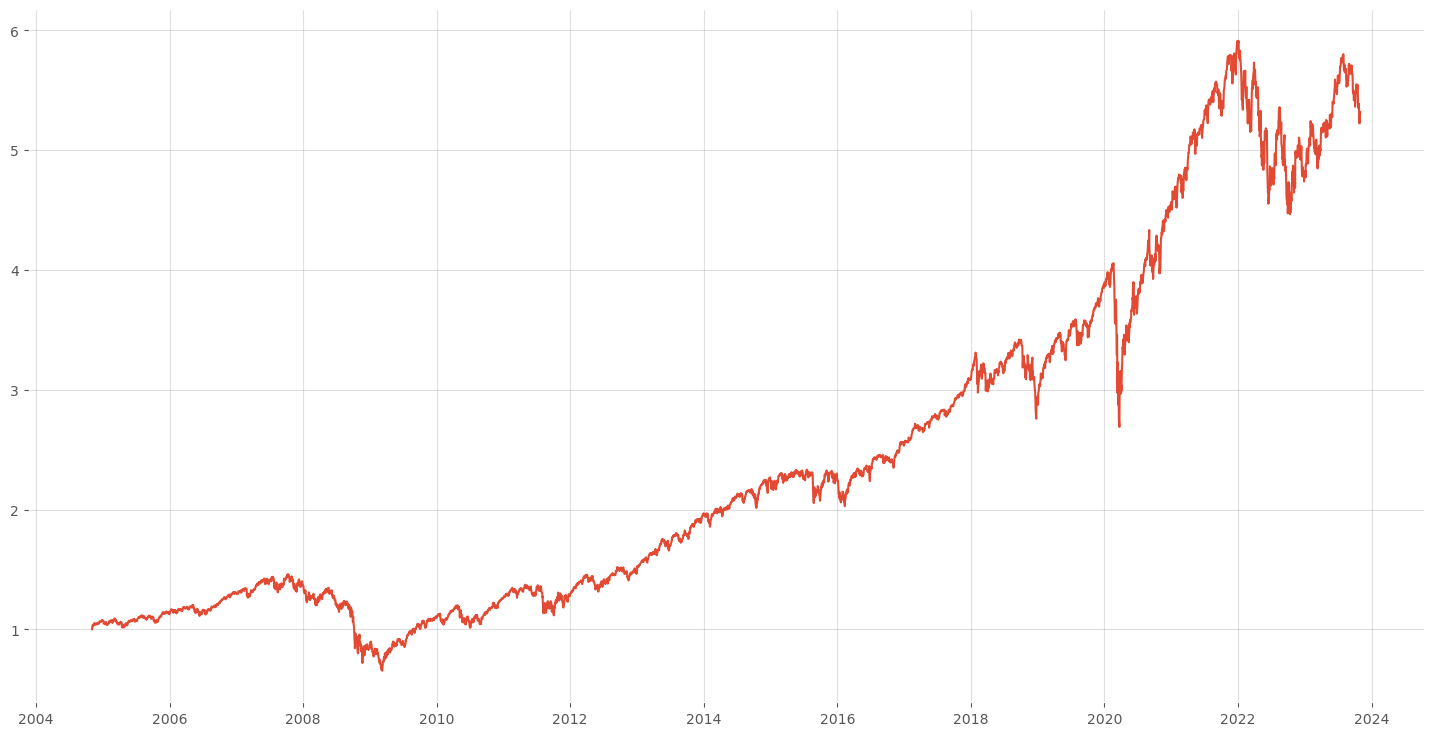

In [4]:
# Baseline
df_baseline = spy[["Adj Close"]]
df_baseline["position"] = 1
df_baseline['cul_return'] = cal_str_cul_return(df_baseline)["cul_return"]

plt.figure(figsize=[18,9])
plt.plot(df_baseline["cul_return"])
plt.show()

## <a id = "p1.1">1.1 </a> <font color = "green"> Momentum Strategy </font>  [back to table of contents](#top)

### <a id = "p1.1.1">1.1.1 </a> <font color = "green"> Simple Moving Average¶ </font>  [back to table of contents](#top) / [Backtesting result](#sm)

> Define Function

In [112]:
def set_SM_position(stock1, short, long):
    stock = stock1.copy()
    
    short = short
    long = long

    stock["long_SMA"] = \
    stock["Adj Close"] \
    .rolling(long,
             min_periods = 1,
             center = False) \
    .mean()
    
    stock["short_SMA"] = \
    stock["Adj Close"]\
    .rolling(short,
             min_periods = 1,
             center = False) \
    .mean()

    stock["SM_position"] = np.where(
                            stock["short_SMA"]
                            >=
                            stock["long_SMA"], 
                            1, 
                            -1)
    stock.dropna(inplace = True)
    return stock["SM_position"]

In [113]:
# Long Only Simple Moving Average

def set_SML_position(stock1, short, long):
    stock = stock1.copy()
    
    short = short
    long = long

    stock["long_SMA"] = \
    stock["Adj Close"] \
    .rolling(long,
             min_periods = 1,
             center = False) \
    .mean()
    
    stock["short_SMA"] = \
    stock["Adj Close"]\
    .rolling(short,
             min_periods = 1,
             center = False) \
    .mean()

    stock["SM_position"] = np.where(
                            stock["short_SMA"]
                            >=
                            stock["long_SMA"], 
                            1, 
                            0)
    stock.dropna(inplace = True)
    return stock["SM_position"]

> Select optimize paramters

In [114]:
def tuning_SM_paras(stock1, short_periods, long_periods):
    stock = stock1.copy()
    parameters = None
    
    best_result = 0
    for short in short_periods:
        for long in long_periods:
            if short < long:
                try:
                    stock['position'] = set_SM_position(stock1, short, long)
                    stock['cul_return'] = cal_str_cul_return(stock)["cul_return"]
                    if stock['cul_return'].iloc[-1] > best_result:
                        best_result = stock['cul_return'].iloc[-1]
                        parameters = (short, long)
                except:
                    continue
                
    return parameters, best_result 

In [115]:
# Best Return
df_strategy_SM_1 = pd.DataFrame(spy['Adj Close'])

short = range(1, 300, 1)
long = range(1, 300, 1)

tuning_SM_paras(df_strategy_SM_1, short, long)

((151, 152), 7.763657439399511)

In [116]:
# Reasonable Return
df_strategy_SM_2 = pd.DataFrame(spy['Adj Close'])

short = range(1, 50, 1)
long = range(100, 250, 1)

tuning_SM_paras(df_strategy_SM_2, short, long)

((46, 161), 4.925570764080768)

### <a id = "p1.1.2">1.1.2 </a> <font color = "green"> Exponential Moving Average¶ </font>  [back to table of contents](#top) / [Backtesting result](#ema)

> Define Function

In [7]:
def set_EM_position(stock1, short, long):
    stock = stock1.copy()
    
    short = short
    long = long

    stock["long_EMA"] = \
    stock["Adj Close"] \
    .ewm(span = long,
         adjust = False) \
    .mean()
    
    stock["short_EMA"] = \
    stock["Adj Close"] \
    .ewm(span = short,
         adjust = False) \
    .mean()

    stock["EM_position"] = np.where(
                            stock["short_EMA"]
                            >=
                            stock["long_EMA"], 
                            1, 
                            -1)
    stock.dropna(inplace = True)
    return stock["EM_position"]

> Select optimize paramters

In [12]:
# def tuning_EM_paras(stock1, short_periods, long_periods):
#     stock = stock1.copy()
#     parameters = None
    
#     best_result = 0
#     for short in short_periods:
#         for long in long_periods:
#             if short < long:
#                 try:
#                     stock['position'] = set_EM_position(stock1, short, long)
#                     stock['cul_return'] = cal_str_cul_return(stock)["cul_return"]
#                     if stock['cul_return'].iloc[-1] > best_result:
#                         best_result = stock['cul_return'].iloc[-1]
#                         parameters = (short, long)
#                 except:
#                     continue
                
#     return parameters, best_result 

In [14]:
# # Best Return
# df_strategy_EM_1 = pd.DataFrame(spy['Adj Close'])

# short = range(1, 300, 1)
# long = range(1, 300, 1)

# tuning_EM_paras(df_strategy_EM_1, short, long)

((175, 278), 7.058064291293605)

In [15]:
# # Reasonable Return
# df_strategy_EM_2 = pd.DataFrame(spy['Adj Close'])

# short = range(8, 20, 1)
# long = range(50, 200, 1)

# tuning_EM_paras(df_strategy_EM_2, short, long)

((10, 65), 4.417461069903444)

## <a id = "p1.2">1.2 </a> <font color = "green"> Mean Reversion </font>  [back to table of contents](#top)

### <a id = "p1.2.1">1.2.1 </a> <font color = "green"> Relative Strength Index(RSI) </font>  [back to table of contents](#top) 

In [9]:
#stock here must be a df with one column called "Adj Close"
def cal_RSI(stock1):
    stock = stock1.copy()
    period = 14

    stock["change"] = stock["Adj Close"].diff()

    stock["gain"] = stock["change"].apply(lambda x: x if x > 0 else 0)
    stock["loss"] = stock["change"].apply(lambda x: -x if x < 0 else 0)

    stock["avg_gain"] = stock["gain"].rolling(period).mean()
    stock["avg_loss"] = stock["loss"].rolling(period).mean()

    for i in range(14,len(stock)):
        stock.iloc[i,4] = (stock.iloc[i-1]["avg_gain"]*13+stock.iloc[i]["gain"])/14
        stock.iloc[i,5] = (stock.iloc[i-1]["avg_loss"]*13+stock.iloc[i]["loss"])/14

    stock["RS"] = stock["avg_gain"]/stock["avg_loss"]
    stock["RSI"] = 100 - 100/(1+stock["RS"])
    
    return stock["RSI"]

In [10]:
#here stock need to be a df with one column named "RSI"
def set_RSI_position(stock1):
    stock = stock1.copy()
    #set RSI_position
    stock["RSI"] = cal_RSI(stock)

    stock["RSI_position"] = np.where(((stock["RSI"]-70)*(stock["RSI"].shift(1)-70)<0)&(stock["RSI"]<70), -1, np.nan)

    #alorithm impovement seems not to imporve....
#     stock["RSI_position"] = np.where(((stock["RSI"]-70)*(stock["RSI"].shift(1)-70)<0)&(stock["RSI"]>70), 0, stock["RSI_position"])
#     stock["RSI_position"] = np.where(((stock["RSI"]-30)*(stock["RSI"].shift(1)-30)<0)&(stock["RSI"]<30), 0, stock["RSI_position"])

    stock["RSI_position"] = np.where(((stock["RSI"]-30)*(stock["RSI"].shift(1)-30)<0)&(stock["RSI"]>30), 1, stock["RSI_position"])
    stock["RSI_position"] = np.where(((stock["RSI"]-50)*(stock["RSI"].shift(1)-50)<0), 0, stock["RSI_position"])
    stock["RSI_position"] = stock["RSI_position"].ffill()
    stock["RSI_position"] = stock["RSI_position"].fillna(0)

    #we need to shift our RSI_position downward cuz we open RSI_position in close price
    stock["RSI_position"] = stock["RSI_position"].shift(1)
    stock["RSI_position"] = stock["RSI_position"].fillna(0)
    return stock["RSI_position"]

### <a id = "p1.2.2">1.2.2 </a> <font color = "green"> Moving Average Convergence Divergence (MACD) </font>  [back to table of contents](#top) 

In [11]:
#here we need stock with column with "Adj Close"
def set_MACD_position(stock1, short, long, signal):
    stock = stock1.copy()
    #short and long EWM
#     short_EWM = 12
#     long_EWM = 26
    short_EWM = short
    long_EWM = long

    stock["short_EWM"] = stock["Adj Close"].ewm(span=short_EWM).mean()
    stock["long_EWM"] = stock["Adj Close"].ewm(span=long_EWM).mean()

    #MACD and MACD signal line
    #signal = 9

    stock["MACD"] = stock["short_EWM"] - stock["long_EWM"]
    stock["MACD_signal"] = stock["MACD"].ewm(span = signal).mean()

    stock["MACD_position"] = np.where(stock["MACD"] > stock["MACD_signal"], 1, -1)
    return stock["MACD_position"]

### <a id = "p1.2.3">1.2.3 </a> <font color = "green"> Bollinger Bands </font>  [back to table of contents](#top)

In [12]:
#as a assist signal
def set_BB_position(stock1, period, multiplier):
    stock = stock1.copy()
    
    stock[f"SMA_{period}"] = stock["Adj Close"].rolling(period).mean()
    stock["upper_threshold"] = multiplier*stock["Adj Close"].rolling(period).std() + stock[f"SMA_{period}"]
    stock["lower_threshold"] = -multiplier*stock["Adj Close"].rolling(period).std() + stock[f"SMA_{period}"]

    distance = stock["Adj Close"] - stock[f"SMA_{period}"]
    stock["BB_position"] = np.where(stock["Adj Close"] > stock["upper_threshold"], -1, np.nan)
    stock["BB_position"] = np.where(stock["Adj Close"] < stock["lower_threshold"], 1, stock["BB_position"])
    stock["BB_position"].ffill(inplace = True)
    stock["BB_position"] = stock["BB_position"].fillna(0)
    
    return stock["BB_position"]

### <a id = "p1.2.4">1.2.4 </a> <font color = "green"> Stochastic Oscillator </font>  [back to table of contents](#top)

In [13]:
def set_SO_position(stock1, period_K, period_D):
    stock = stock1.copy()

    stock["min"] = stock["Adj Close"].rolling(period_K).min()
    stock["max"] = stock["Adj Close"].rolling(period_K).max()
    percentage_K = 100*(stock["Adj Close"] - stock["min"])/(stock["max"]-stock["min"])
    percentage_D = percentage_K.rolling(period_D).mean()
    
    stock["SO_position"] = np.where(percentage_K>percentage_D, 1, -1)
    stock["SO_position"] = stock["SO_position"].fillna(0)
    return stock["SO_position"]

### <a id = "p1.2.5">1.2.5 </a> <font color = "green"> Commodity Channel Index </font>  [back to table of contents](#top)

In [14]:
# period = 20
# constant = 0.015
#stock data with columns with "High", " Low" ,"Close"
def set_CCI_position(stock1, period, constant):
    stock = stock1.copy()
    
    stock["typical_price"] = (stock["High"] + stock["Low"] + stock["Close"])/3
    stock["SMA"] = stock["Close"].rolling(period).mean()
    stock["typical_price_std"] = stock["typical_price"].rolling(period).std()

    CCI = (stock["typical_price"] - stock["SMA"])/(constant*stock["typical_price_std"])
    stock["CCI_position"] = np.where(CCI > 100, -1, np.nan)
    stock["CCI_position"] = np.where(CCI < -100, 1, stock["CCI_position"])
    
    stock["CCI_position"].ffill(inplace = True)
    stock["CCI_position"] = stock["CCI_position"].fillna(0)
    return stock["CCI_position"]

### <a id = "p1.2.6">1.2.6 </a> <font color = "green"> Momentum Indicator Crossover Strategy </font>  [back to table of contents](#top)

In [96]:
def set_MICS_position(stock1, period, buy_threshold, sell_threshold):
    stock = stock1.copy()
    
    spy['momentum'] = spy['Adj Close'].diff(period)
    spy["MICS_position"] = np.where(spy["momentum"]> buy_threshold, 1, -1)
    return spy["MICS_position"]

## <a id = "p1.3">1.3 </a> <font color = "green"> Machine Learning </font>  [back to table of contents](#top) / [Backtesting result](#ml)

In [7]:
spy = ['SPY']

stock_ticker = ['QQQ', '^TNX']
currency_ticker = ["DEXJPUS", "DEXUSEU", "DEXUSUK", "DEXCAUS"]

index_ticker = ["VIXCLS"]

stock_data = pdr.get_data_yahoo(stock_ticker, start = dt.datetime(2004, 11, 1), end = dt.datetime(2023, 10, 31))
spy =  pdr.get_data_yahoo(spy, start = dt.datetime(2004, 11, 1), end = dt.datetime(2023, 10, 31))
currency_data = pdr.get_data_fred(currency_ticker, start = dt.datetime(2004, 11, 1), end = dt.datetime(2023, 10, 31))
index_data = pdr.get_data_fred(index_ticker, start = dt.datetime(2004, 11, 1), end = dt.datetime(2023, 10, 31))

[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  1 of 1 completed


In [8]:
return_period = 5

In [9]:
Y =\
    (np
     .log(spy.loc[ : , 'Adj Close']
         )
     .diff(return_period)
     .shift(-return_period)
    )

Y = Y.rename('SPY')

In [10]:
Y.name =\
    (Y
     .name
     +
     "_pred")

In [11]:
X1 = pd.DataFrame(np.log(stock_data.loc[ : , "Adj Close"]).diff(return_period))

X1.columns = ['QQQ', '10Y']

In [12]:
X2 =\
    (np
     .log(currency_data)
     .diff(return_period)
    )

In [13]:
X3 =\
    (np
     .log(index_data)
     .diff(return_period)
    )

In [14]:
X4 =\
    (
    pd
    .concat([np
             .log(spy.loc[ : , "Adj Close"
                                ]
                 )
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]
            ],
           axis = 1
           )
    .dropna()
)

X4.columns = ["SPY_DT", "SPY_3DT", "SPY_6DT", "SPY_12DT"]

In [15]:
X5 = pd.DataFrame(spy['Adj Close'].diff(30))
X5.columns = ['SPY_DT']

In [16]:
X=\
(
    pd
    .concat([X1, X2, X3, X5],
            axis = 1)
)

X

,QQQ,10Y,DEXJPUS,DEXUSEU,DEXUSUK,DEXCAUS,VIXCLS,SPY_DT
2004-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-10-25,-0.036517,0.009942,0.000534,0.004831,-0.000823,0.005534,0.049236,-27.390564
2023-10-26,-0.046368,-0.029088,0.003463,-0.003602,-0.002638,0.008277,-0.034224,-36.227020
2023-10-27,-0.026548,-0.016174,-0.001670,0.000000,-0.000165,0.012628,-0.020475,-32.690002
2023-10-30,-0.018359,0.007619,-0.005154,-0.002445,-0.006396,0.011125,-0.030910,-28.040009


In [17]:
data =\
(
pd
.concat([Y, X],
        axis = 1)
.dropna()
.iloc[ : :return_period, :]
)

data

,SPY_pred,QQQ,10Y,DEXJPUS,DEXUSEU,DEXUSUK,DEXCAUS,VIXCLS,SPY_DT
2004-12-14,0.001396,0.022484,-0.022731,0.027362,-0.011753,-0.011370,0.023627,-0.071242,5.290123
2004-12-21,0.008025,-0.010429,0.008675,-0.012005,0.007278,0.001247,-0.008601,-0.097276,2.913956
2004-12-29,-0.027992,0.008532,0.036282,0.002306,0.013206,0.001672,-0.019214,0.014738,2.225189
2005-01-06,-0.008382,-0.041874,0.002109,0.016925,-0.032528,-0.024704,0.025129,0.078081,0.701797
2005-01-13,-0.007167,-0.007328,-0.020098,-0.022371,0.001515,0.004310,-0.030032,-0.056033,-0.732452
...,...,...,...,...,...,...,...,...,...
2023-09-19,-0.038757,-0.006417,0.023410,0.004611,-0.003923,-0.006755,-0.009042,-0.008469,-6.415771
2023-09-26,-0.010124,-0.043262,0.043266,0.007415,-0.010444,-0.018322,0.005791,0.294392,-20.654907
2023-10-03,0.030255,0.002003,0.052149,0.001745,-0.011415,-0.008169,0.015498,0.043395,-16.205750
2023-10-11,-0.014102,0.031386,-0.030013,0.002282,0.009651,0.012019,-0.008919,-0.143888,-11.261230


In [18]:
Y = data.loc[ : , Y.name]
X = data.loc[ : , X.columns]

In [19]:
# cross-validation is not testing set

validation_size = 0.25 # this refers to testing set

train_size =\
    int(len(X) 
        * 
        (1 - validation_size)
       )

X_train, X_test =\
    (X[0         :train_size], 
     X[train_size:len(X)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size], 
     Y[train_size:len(X)    ]
    )

In [20]:
models = []

In [21]:
models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )

# Use 'SVC' for Support Vector Regression in sklearn package

# Bagging (Boostrap Aggregation)

models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor() #Adaptive boosting
              )
             )

## Light GBM
## CAT Boost

models

[('LR', LinearRegression()),
 ('LASSO', Lasso()),
 ('EN', ElasticNet()),
 ('CART', DecisionTreeRegressor()),
 ('KNN', KNeighborsRegressor()),
 ('SVR', SVR()),
 ('RFR', RandomForestRegressor()),
 ('ETR', ExtraTreesRegressor()),
 ('GBR', GradientBoostingRegressor()),
 ('ABR', AdaBoostRegressor())]

In [22]:
num_folds = 10
seed = 9
scoring = "neg_mean_squared_error"

In [23]:
### Initialization of Lists:

names = []

kfold_results = []

train_results = []
test_results = []

result_df = pd.DataFrame()

for name, model in models:
    names.append(name)
    
    kfold =\
        (KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        )
    
    cv_results =\
        (
         -1
         *
         cross_val_score(model, X_train, Y_train,
                         cv = kfold,
                         scoring = scoring)
        )
    
    kfold_results.append(cv_results)
    
    res = model.fit(X_train, Y_train)
    
    train_result = mean_squared_error(res.predict(X_train), Y_train)
        
    train_results.append(train_result)
    
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    
    test_results.append(test_result)
    
    predict_df = pd.DataFrame(res.predict(X_test), index = X_test.index)
    
    result_df.loc[: , name] = predict_df
    
    message = "%s: %f (%f) %f" % (name, cv_results.mean(), 
                                     cv_results.std(), 
                                     train_result,
                                    )
    print(message)

LR: 0.000515 (0.000164) 0.000490
LASSO: 0.000501 (0.000157) 0.000499
EN: 0.000501 (0.000157) 0.000499
CART: 0.001305 (0.000386) 0.000000
KNN: 0.000586 (0.000172) 0.000390
SVR: 0.001225 (0.000182) 0.001263
RFR: 0.000623 (0.000197) 0.000087
ETR: 0.000612 (0.000192) 0.000000
GBR: 0.000676 (0.000241) 0.000210
ABR: 0.000635 (0.000266) 0.000393


In [24]:
test_df = result_df.copy()
test_df.head()

,LR,LASSO,EN,CART,KNN,SVR,RFR,ETR,GBR,ABR
2019-01-25,-0.001854,0.001695,0.001695,0.016637,-0.006648,-0.031445,-0.002079,-0.002066,-0.002941,-0.002043
2019-02-04,0.000112,0.001695,0.001695,0.004505,-0.005853,-0.010735,-0.010041,-0.015334,-0.018031,-0.004244
2019-02-11,0.001795,0.001695,0.001695,0.030626,-0.005853,-0.010735,-0.005103,-0.005324,-0.015401,-0.004115
2019-02-19,-0.002781,0.001695,0.001695,-0.004868,-0.005853,-0.010735,-0.008847,-0.018681,-0.020364,-0.003751
2019-03-01,-0.003008,0.001695,0.001695,-0.011456,-0.005853,-0.010737,-0.005025,-0.005631,-0.016587,-0.004244


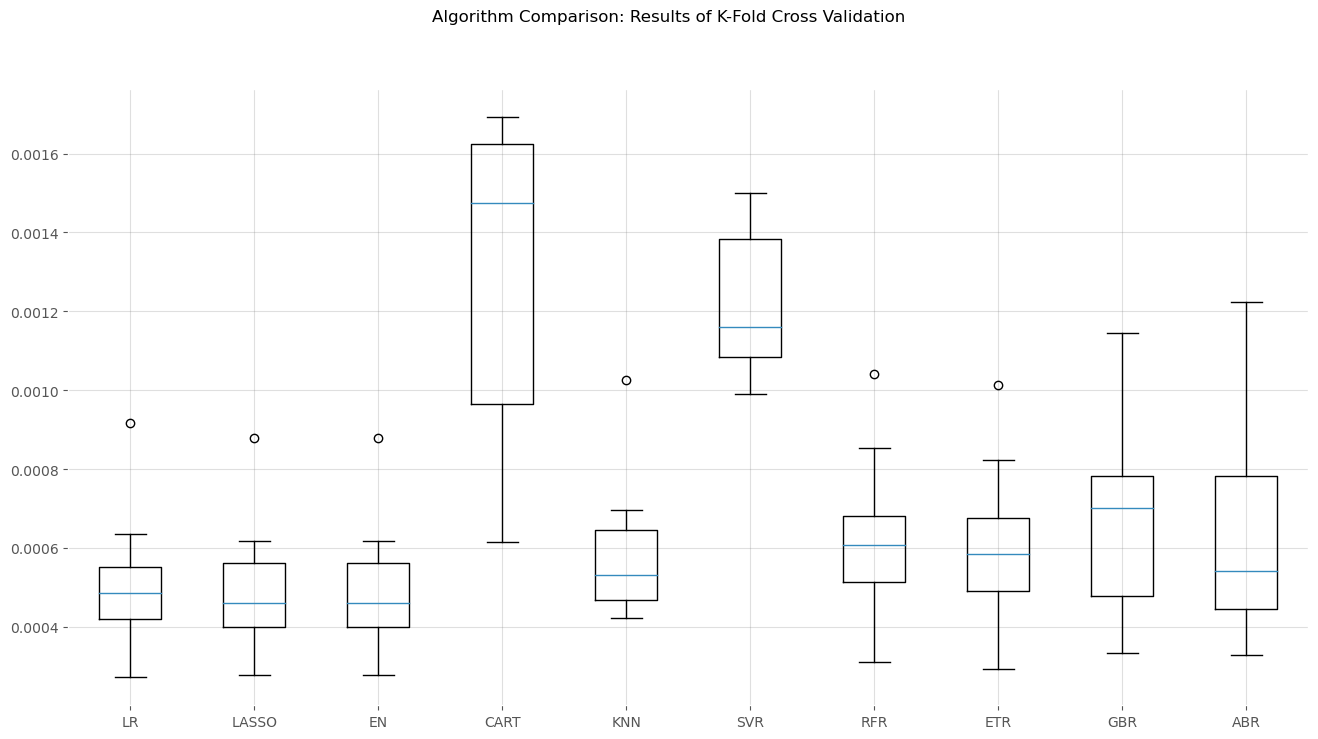

In [25]:
fig = plt.figure(figsize = [16, 8]
                )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)

ax.set_xticklabels(names)

plt.show()

In [26]:
# Basic Set-up for ARIMA

X_train_ARIMA =\
    (X_train
    .loc[ : , ["QQQ", "10Y", "DEXJPUS", "DEXUSEU", "DEXUSUK", "DEXCAUS", "VIXCLS", "SPY_DT"]]
   )

X_test_ARIMA =\
    (X_test
    .loc[ : , ["QQQ", "10Y", "DEXJPUS", "DEXUSEU", "DEXUSUK", "DEXCAUS", "VIXCLS", "SPY_DT"]]
)    

train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)

In [27]:
# Hyperparameter Tuning; Grid Search for ARIMA

def assess_ARIMA_model(arima_order):
    
    modelARIMA = stats.ARIMA(endog = Y_train, 
                             exog = X_train_ARIMA,
                             order = arima_order)
    
    model_fit = modelARIMA.fit()
    
    error = mean_squared_error(Y_train,
                               model_fit.fittedvalues)
    
    return error

def assess_models(p_values, d_values, q_values):
    
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = assess_ARIMA_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    
                    print("ARIMA%s MSE = %.7f" % (order, mse)
                          )
                    
                except:
                    continue
    print("Best ARIMA%s MSE = %.7f" % (best_cfg, best_score)
          )
    
# parameters to use for assessment

p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)

In [28]:
assess_models(p_values, d_values, q_values)

/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wil

ARIMA(0, 0, 0) MSE = 0.0004902
ARIMA(0, 0, 1) MSE = 0.0004898


/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(0, 1, 0) MSE = 0.0007463


/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

ARIMA(0, 1, 1) MSE = 0.0005207
ARIMA(1, 0, 0) MSE = 0.0004898
ARIMA(1, 0, 1) MSE = 0.0004902


/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wil

ARIMA(1, 1, 0) MSE = 0.0006290


/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forec

ARIMA(1, 1, 1) MSE = 0.0005158
ARIMA(2, 0, 0) MSE = 0.0004897


/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 1) MSE = 0.0004902


/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

ARIMA(2, 1, 0) MSE = 0.0005935
ARIMA(2, 1, 1) MSE = 0.0005227
Best ARIMA(2, 0, 0) MSE = 0.0004897


/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
modelARIMA =\
(    stats
     .ARIMA(endog = Y_train,
                exog = X_train_ARIMA,
                order = [2, 0, 0]
            )
)

model_fit = modelARIMA.fit()

/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [30]:
error_training_ARIMA =\
(    mean_squared_error(Y_train,
                       model_fit.fittedvalues)
)

predicted =\
(
    model_fit
    .predict(start = train_len - 1,
             end = total_len - 1,
             exog = X_test_ARIMA)[1: ]
)

/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [31]:
error_testing_ARIMA =\
(    mean_squared_error(Y_test,
                        predicted)
)

error_testing_ARIMA

0.0008940074320397143

In [32]:
test_results.append(error_testing_ARIMA)

train_results.append(error_training_ARIMA)

names.append("ARIMA")

In [33]:
ARIMA_predict = pd.DataFrame(model_fit.predict(start = train_len - 1,
                 end = total_len - 2,
                 exog = X_test_ARIMA[1: ]))

ARIMA_predict = np.array(ARIMA_predict)
test_df.loc[:, 'ARIMA'] = ARIMA_predict
test_df.head()

/Users/shannon423/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,LR,LASSO,EN,CART,KNN,SVR,RFR,ETR,GBR,ABR,ARIMA
2019-01-25,-0.001854,0.001695,0.001695,0.016637,-0.006648,-0.031445,-0.002079,-0.002066,-0.002941,-0.002043,-0.000427
2019-02-04,0.000112,0.001695,0.001695,0.004505,-0.005853,-0.010735,-0.010041,-0.015334,-0.018031,-0.004244,0.000077
2019-02-11,0.001795,0.001695,0.001695,0.030626,-0.005853,-0.010735,-0.005103,-0.005324,-0.015401,-0.004115,0.002018
2019-02-19,-0.002781,0.001695,0.001695,-0.004868,-0.005853,-0.010735,-0.008847,-0.018681,-0.020364,-0.003751,-0.002787
2019-03-01,-0.003008,0.001695,0.001695,-0.011456,-0.005853,-0.010737,-0.005025,-0.005631,-0.016587,-0.004244,-0.003003


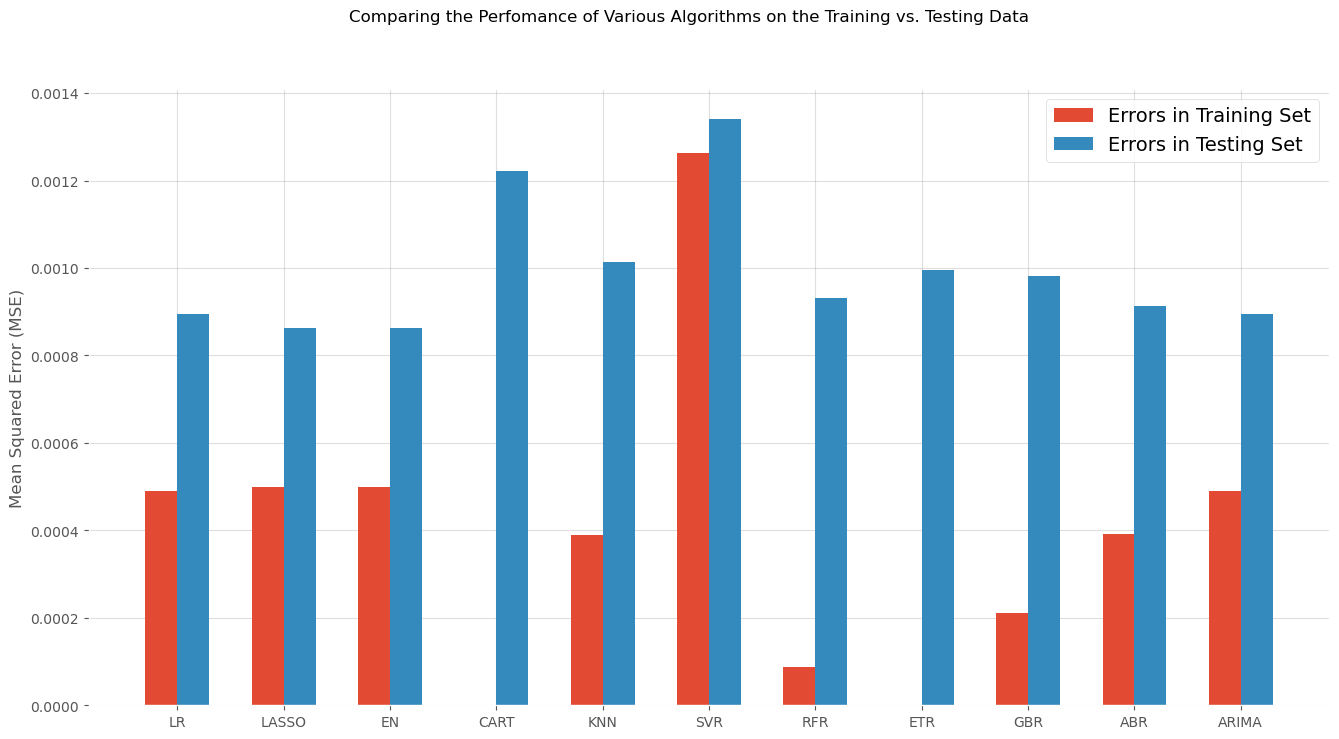

In [34]:
fig = plt.figure(figsize = [16, 8])

ind = np.arange(len(names)
               )

width = 0.30

fig.suptitle("Comparing the Perfomance of Various Algorithms on the Training vs. Testing Data")

ax = fig.add_subplot(111)

(plt
 .bar(ind - width/2,
      train_results,
      width = width,
      label = "Errors in Training Set")
)

(plt
 .bar(ind + width/2,
      test_results,
      width = width,
      label = "Errors in Testing Set")
)

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error (MSE)")

plt.show()

In [35]:
SPY_log = Y_test.to_frame()
SPY_log['capital'] = 1e5

SPY_log['position'] = 0
SPY_log['position'] = np.sign(SPY_log['SPY_pred'])

SPY_log['strategy'] = 0
SPY_log['strategy'] = SPY_log['SPY_pred'] * SPY_log['position']

SPY_sharpe = np.sqrt(253) * (SPY_log['SPY_pred'].mean()/SPY_log['SPY_pred'].std())

for i in range(len(SPY_log)):
    SPY_log['capital'][i] = \
    SPY_log['capital'][i-1] * (SPY_log['SPY_pred'].apply(np.exp)[i])

SPY_days = (SPY_log.index[-1] - SPY_log.index[0]).days
SPY_cagr = ((((SPY_log['capital'][-1]) / (SPY_log['capital'][0]))**(365.0/SPY_days))- 1)

window = 253
spy_rolling_max = SPY_log['capital'].rolling(window = window, min_periods = 1).max()
spy_daily_drawdown = SPY_log['capital'] / spy_rolling_max - 1.0
spy_max_daily_drawdown = spy_daily_drawdown.rolling(window = window, min_periods = 1).min()

spy_metrics = "SPY| Capital: %s Sharpe: %.3f CAGR: %.3f Max_DD: %.3f" % (SPY_log['capital'][-1], SPY_sharpe, SPY_cagr, spy_max_daily_drawdown.min())
print(spy_metrics)

SPY_log

SPY| Capital: 151637.80736736296 Sharpe: 0.995 CAGR: 0.088 Max_DD: -0.362


,SPY_pred,capital,position,strategy
2019-01-25,0.015975,101610.361140,1.0,0.015975
2019-02-04,-0.004939,101109.715904,-1.0,0.004939
2019-02-11,0.026366,103811.038809,1.0,0.026366
2019-02-19,0.005277,104360.253231,1.0,0.005277
2019-03-01,-0.021483,102142.175296,-1.0,0.021483
...,...,...,...,...
2023-09-19,-0.038757,155797.605135,-1.0,0.038757
2023-09-26,-0.010124,154228.212232,-1.0,0.010124
2023-10-03,0.030255,158965.652040,1.0,0.030255
2023-10-11,-0.014102,156739.573381,-1.0,0.014102


## <a id = "p1.4">1.4 </a> <font color = "green"> Combine Strategy </font>  [back to table of contents](#top)

### <a id = "p1.4.1">1.4.1 </a> <font color = "green">  SML + MACD </font>  [back to table of contents](#top)

In [126]:
# Only can long
def set_SML_MACD_position(stock1, SML_short, SML_long, MACD_short, MACD_long, MACD_signal):
    stock = stock1.copy()
    
    stock["SML_position"] = set_SML_position(stock, SML_short, SML_long)
    stock["MACD_position"] = set_MACD_position(stock, MACD_short, MACD_long, MACD_signal)
    stock["position"] = np.where((stock["SML_position"]== 1) | (stock["MACD_position"] ==1), 
                                  1,
                                  0)
    
    return stock["position"]

In [127]:
def tuning_SML_MACD_paras(stock1, SML_shorts, SML_longs, MACD_shorts, MACD_longs, MACD_signals):
    stock = stock1.copy()
    parameters = (0, 0, 0, 0, 0)
    
    best_result = 0
    for SML_short in SML_shorts:
        for SML_long in SML_longs:
            for MACD_short in MACD_shorts:
                for MACD_long in MACD_longs:
                    for MACD_signal in MACD_signals:
                        if (MACD_short < MACD_long) & (SML_short < SML_long):
                            try:
                                stock["position"] = set_SML_MACD_position(stock, SML_short, SML_long, MACD_short, MACD_long, MACD_signal)
                                stock['cul_return'] = cal_str_cul_return(stock)["cul_return"]
                                if stock['cul_return'].iloc[-1] > best_result:
                                    best_result = stock['cul_return'].iloc[-1]
                                    parameters = (SML_short, SML_long, MACD_short, MACD_long, MACD_signal)
                            except Exception as e:
                                print(f"Error: {e}")
                                continue
                                
    return parameters, best_result 

In [15]:
df_strategy_SML_MACD = pd.DataFrame(spy['Adj Close'])

SML_shorts = [5,10,20]
SML_longs = [50, 100, 200]
MACD_shorts = [5,10,20]
MACD_longs = [20,30,60]
MACD_signals = range(5, 10)

tuning_SML_MACD_paras(df_strategy_SML_MACD, SML_shorts, SML_longs, MACD_shorts, MACD_longs, MACD_signals)

((10, 200, 20, 30, 5), 6.551696286362009)

### <a id = "p1.4.2">1.4.2 </a> <font color = "green">  SM + MACD </font>  [back to table of contents](#top) / [Backtesting result](#smmacd)

In [160]:
def set_SM_MACD_position(stock1, SM_short, SM_long, MACD_short, MACD_long, MACD_signal):
    stock = stock1.copy()
    
    stock["SM_position"] = set_SM_position(stock, SM_short, SM_long)
    stock["MACD_position"] = set_MACD_position(stock, MACD_short, MACD_long, MACD_signal)
    stock["position"] = np.where((stock["SM_position"]== 1) | (stock["MACD_position"] ==1), 
                                  1,
                                  -1)
    
    return stock["position"]

In [161]:
def tuning_SM_MACD_paras(stock1, SM_shorts, SM_longs, MACD_shorts, MACD_longs, MACD_signals):
    stock = stock1.copy()
    parameters = (0, 0, 0, 0, 0)
    
    best_result = 0
    for SM_short in SM_shorts:
        for SM_long in SM_longs:
            for MACD_short in MACD_shorts:
                for MACD_long in MACD_longs:
                    for MACD_signal in MACD_signals:
                        if (MACD_short < MACD_long) & (SM_short < SM_long):
                            try:
                                stock["position"] = set_SM_MACD_position(stock, SM_short, SM_long, MACD_short, MACD_long, MACD_signal)
                                stock['cul_return'] = cal_str_cul_return(stock)["cul_return"]
                                if stock['cul_return'].iloc[-1] > best_result:
                                    best_result = stock['cul_return'].iloc[-1]
                                    parameters = (SM_short, SM_long, MACD_short, MACD_long, MACD_signal)
                            except Exception as e:
                                print(f"Error: {e}")
                                continue
                                
    return parameters, best_result 

In [162]:
df_strategy_SM_MACD = pd.DataFrame(spy['Adj Close'])

# SM_shorts = range(5, 50, 5)
# SM_longs = range(100, 250, 5)
# MACD_shorts = range(5, 20, 5)
# MACD_longs = range(50, 200, 5)
# MACD_signals = range(5, 20, 1)

SM_shorts = [5,10,20]
SM_longs = [50, 100, 200]
MACD_shorts = [5,10,20]
MACD_longs = [20,30,60]
MACD_signals = range(5, 10)

In [163]:
tuning_SM_MACD_paras(df_strategy_SM_MACD, SM_shorts, SM_longs, MACD_shorts, MACD_longs, MACD_signals)

((10, 200, 20, 30, 5), 8.0191038642684)

### <a id = "p1.4.3">1.4.3 </a> <font color = "green">  Stochastic Oscillator + Momentum Indicator Crossover Strategy </font>  [back to table of contents](#top) / [Backtesting result](#somics)

In [174]:
def SO_MICS_cul_return(stock1, SO_period_K, SO_period_D, MICS_period, MICS_buy, MICS_sell):
    stock = stock1.copy()
    stock = stock[["Adj Close"]]

    stock["SO_position"] = set_SO_position(stock, SO_period_K, SO_period_D)
    stock["MICS_position"] = set_MICS_position(stock, MICS_period, MICS_buy, MICS_sell)

    stock["position"] = -np.where((stock["SO_position"])==(stock["MICS_position"]), stock["SO_position"], 0)
    stock = cal_str_cul_return(stock)
    final_result = stock["cul_return"][-1]
    return final_result

In [175]:
def SO_MICS_tuning(stock1, SO_periods_K, SO_periods_D, MICS_periods, MICS_buys, MICS_sells):
    stock = stock1.copy()
    best_res = 0
    best_parameters = (0,0,0,0)
    
    for SO_period_K in SO_periods_K:
        for SO_period_D in SO_periods_D:
            for MICS_period in MICS_periods:
                for MICS_buy in MICS_buys:
                    for MICS_sell in MICS_sells:
                        parameters = (SO_period_K, SO_period_D, MICS_period, MICS_buy, MICS_sell)
                        res = SO_MICS_cul_return(stock, SO_period_K, SO_period_D, MICS_period, MICS_buy, MICS_sell)
                        if(res > best_res):
                            best_res = res
                            best_parameters = parameters
    return best_res, best_parameters

In [176]:
SO_periods_K = range(10,16)
SO_periods_D = range(3,7)
MICS_periods = range(5,20,5)
MICS_buys = np.arange(0,0.1, 0.005)
MICS_sells = np.arange(-0.1, 0, 0.005)

SO_MICS_tuning(df_strategy, SO_periods_K, SO_periods_D, MICS_periods, MICS_buys, MICS_sells)

(7.664957703910786, (10, 6, 5, 0.065, -0.1))

# <a id = "p2"> </a> <font color = "green"> PART2 BACKTESTING </font>  [back to table of contents](#top)

> Define Function

In [177]:
def backtesting(df_strategy, capital):
    left_money = capital * df_strategy["cul_return"].iloc[-1]
    
    print(f"After trading, {left_money} amount of money left.")
    
    # sharpe ratio
    sharpe_ratio = np.sqrt(253)*np.mean(df_strategy["str_return"])/np.std(df_strategy["str_return"])
    print(f"Sharpe Ratio is {sharpe_ratio}")
    
    # cagr
    days = (df_strategy.index[-1] - df_strategy.index[0]).days
    cagr = np.exp(sum(df_strategy["str_return"].dropna()))**(365/days)-1
    print(f"Compound Annual Growth Rate (CAGR) is {cagr}")
    
    #Calculate the maximum drawdowns  
    df_strategy["Max_performance"] = df_strategy["cul_return"].cummax()
    df_strategy["Drawdown"] = -(df_strategy["cul_return"] - df_strategy["Max_performance"])/df_strategy["Max_performance"]
    max_drawdown = df_strategy["Drawdown"].max()
    print(f"Max drawdown is {max_drawdown}")
    
    # visualize cul return
    plt.figure(figsize=[18,9])
    plt.plot(df_baseline["cul_return"],label='Baseline')
    plt.plot(df_strategy["cul_return"],label='Strategy')
    plt.legend()
    plt.show()

    #visualize maximum drawdown
    plt.figure(figsize=(18, 9))
    plt.plot(df_strategy["cul_return"], label="Cumulative Return", linewidth=2)
    plt.plot(df_strategy["Max_performance"], label="Max Performance", linewidth=2)

    plt.title("Maximum Drawdown")
    plt.legend()  # Display legend with labels
    plt.show()

In [171]:
capital = 1e5
df_strategy = pd.DataFrame(spy['Adj Close'])

### <a id = "sm"> </a> <font color = "green"> Simple Moving Average </font>  [back to table of contents](#top) / [Strategy](#p1.1.1)

#### SM - Best return

After trading, 776365.7439399511 amount of money left.
Sharpe Ratio is 0.5602656557547329
Compound Annual Growth Rate (CAGR) is 0.1138638058801591
Max drawdown is 0.3371727549842227


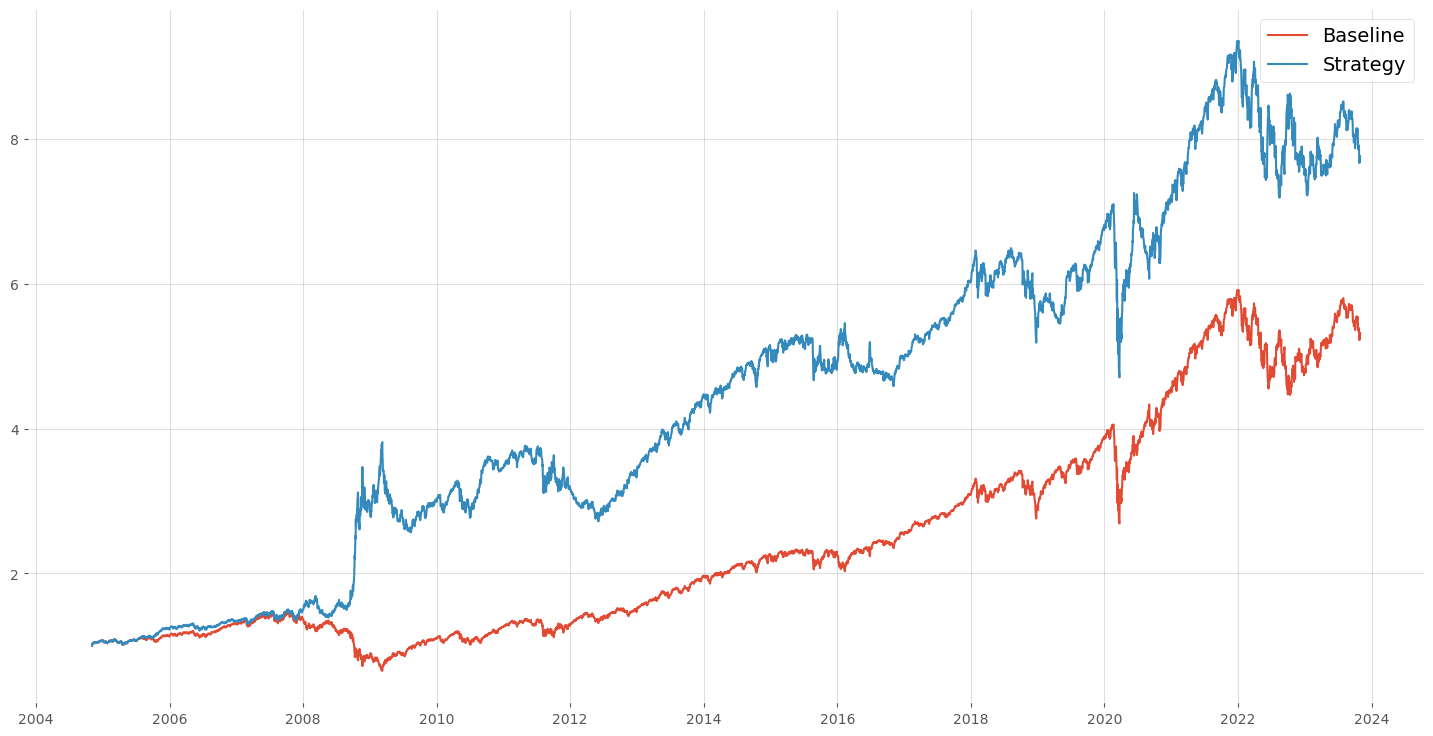

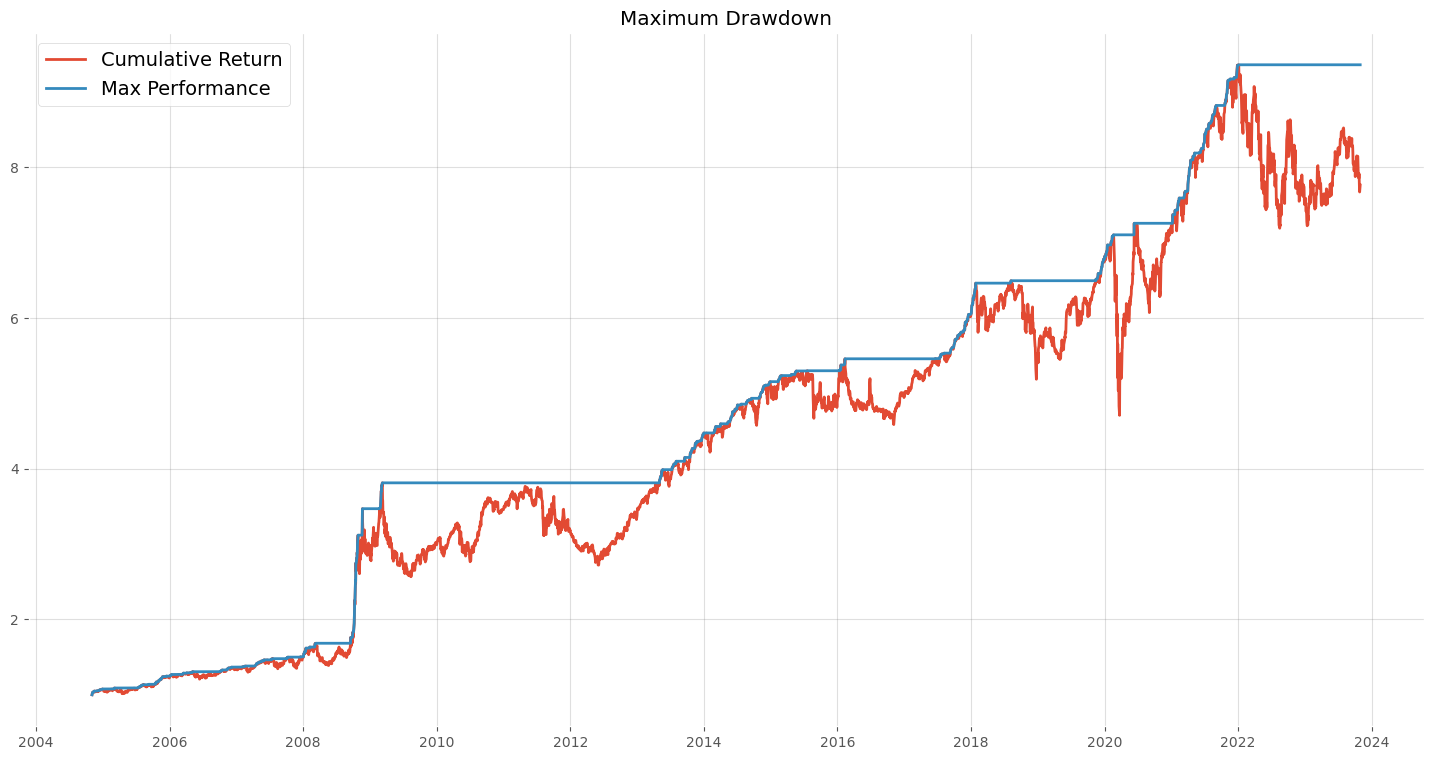

In [172]:
df_strategy_SM = df_strategy
df_strategy_SM['position']= set_SM_position(df_strategy_SM, 151, 152)
df_strategy_SM[['str_return', 'cul_return']] = cal_str_cul_return(df_strategy_SM)[['str_return', 'cul_return']]
backtesting(df_strategy_SM, capital)

### <a id = "ema"> </a> <font color = "green"> Exponential Moving Average </font>  [back to table of contents](#top) / [Strategy](#p1.1.2)

#### EMA - Best Return

After trading, 692433.6839681346 amount of money left.
Sharpe Ratio is 0.5291224203056932
Compound Annual Growth Rate (CAGR) is 0.10717858942309699
Max drawdown is 0.4225263899036326


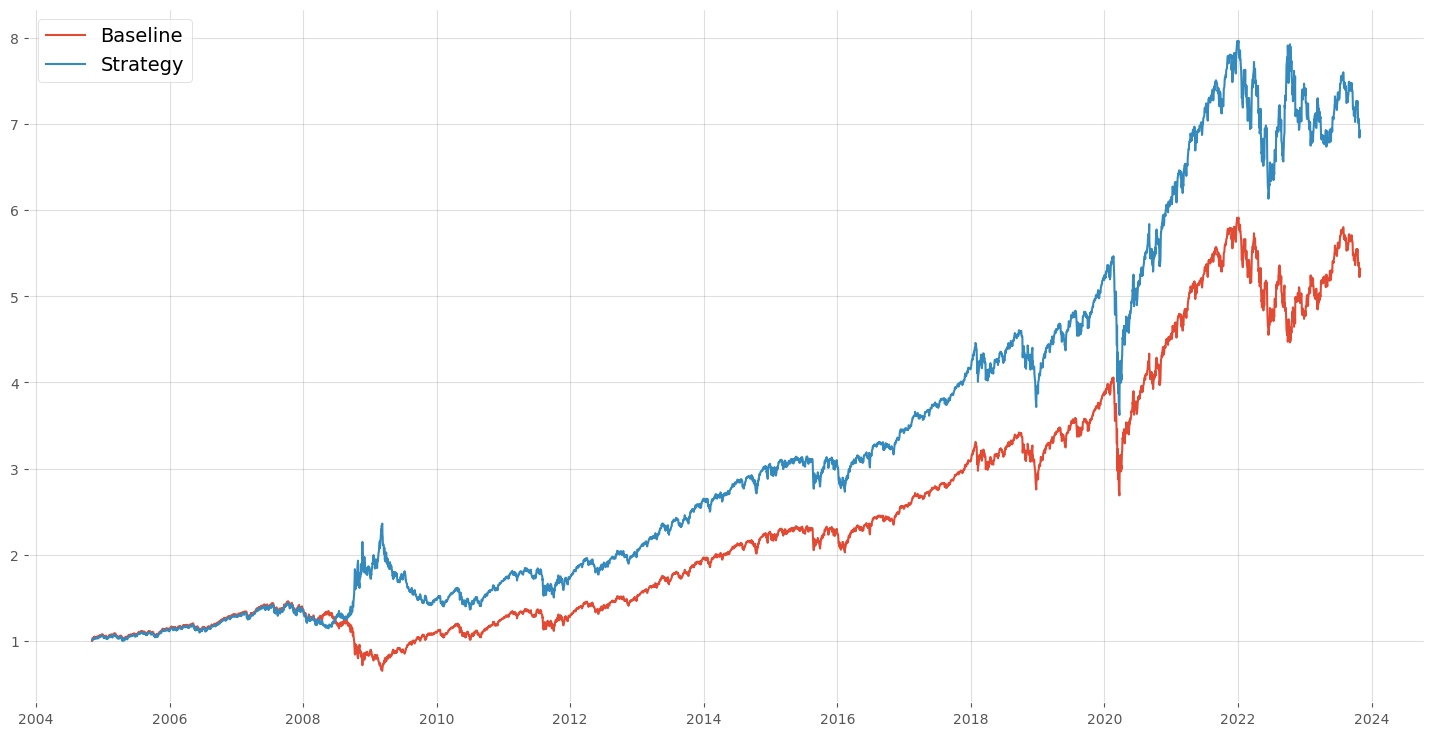

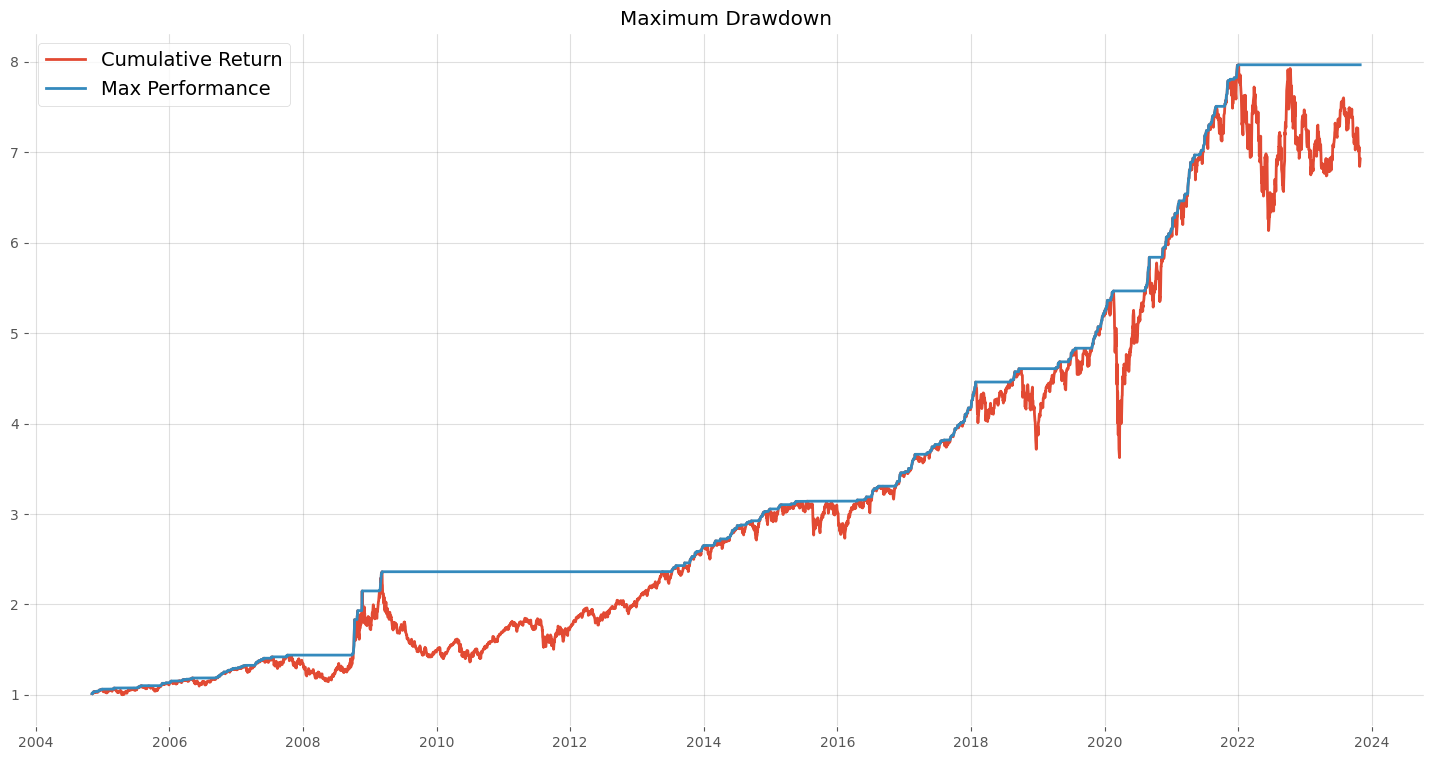

In [144]:
df_strategy_EM = df_strategy
df_strategy_EM['position']= set_EM_position(df_strategy_EM, 175, 278)
df_strategy_EM[['str_return', 'cul_return']] = cal_str_cul_return(df_strategy_EM)[['str_return', 'cul_return']]
backtesting(df_strategy_EM, capital)

### <a id = "ml"> </a> <font color = "green"> Machine Learning </font>  [back to table of contents](#top) / [Strategy](#p1.3)

LR| Capital: 234253.5908387982 Sharpe: 2.047 CAGR: 0.201 Max_DD: -0.355
LASSO| Capital: 151637.80736736296 Sharpe: 0.995 CAGR: 0.088 Max_DD: -0.362
EN| Capital: 151637.80736736296 Sharpe: 0.995 CAGR: 0.088 Max_DD: -0.362
CART| Capital: 288157.9851464314 Sharpe: 2.557 CAGR: 0.246 Max_DD: -0.159
KNN| Capital: 85497.22276130859 Sharpe: -0.374 CAGR: -0.029 Max_DD: -0.393
SVR| Capital: 89673.2290488483 Sharpe: -0.260 CAGR: -0.019 Max_DD: -0.458
RFR| Capital: 108068.63485387796 Sharpe: 0.185 CAGR: 0.020 Max_DD: -0.243
ETR| Capital: 70810.62784191857 Sharpe: -0.824 CAGR: -0.067 Max_DD: -0.555
GBR| Capital: 152764.39023249384 Sharpe: 1.013 CAGR: 0.097 Max_DD: -0.212
ABR| Capital: 150555.96915981494 Sharpe: 0.978 CAGR: 0.094 Max_DD: -0.229
ARIMA| Capital: 234253.5908387982 Sharpe: 2.047 CAGR: 0.201 Max_DD: -0.355


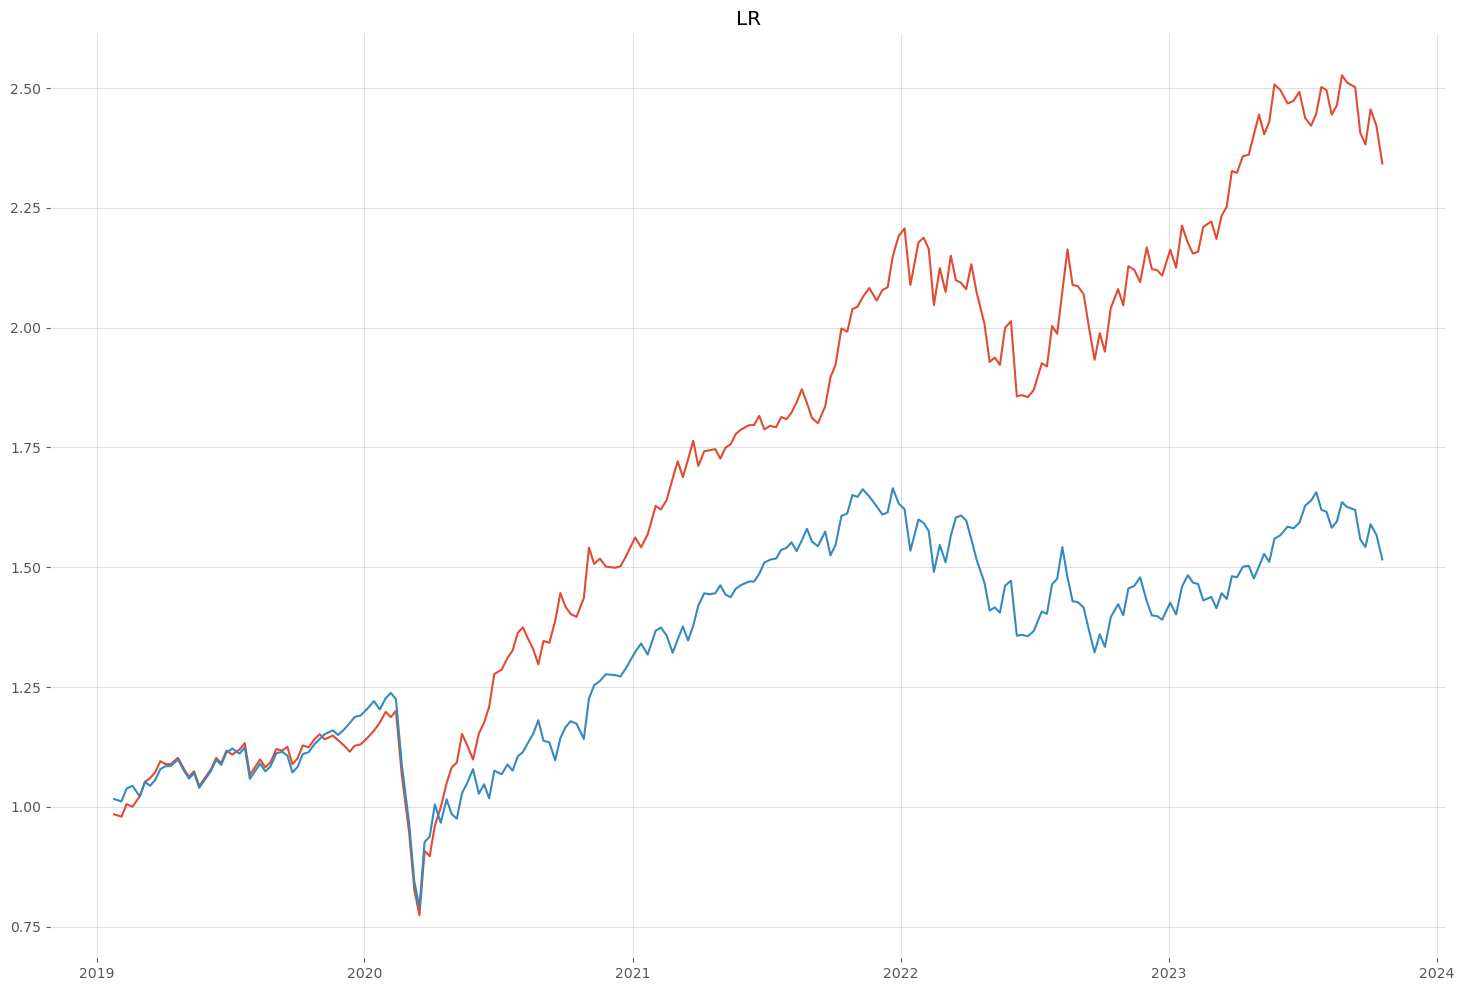

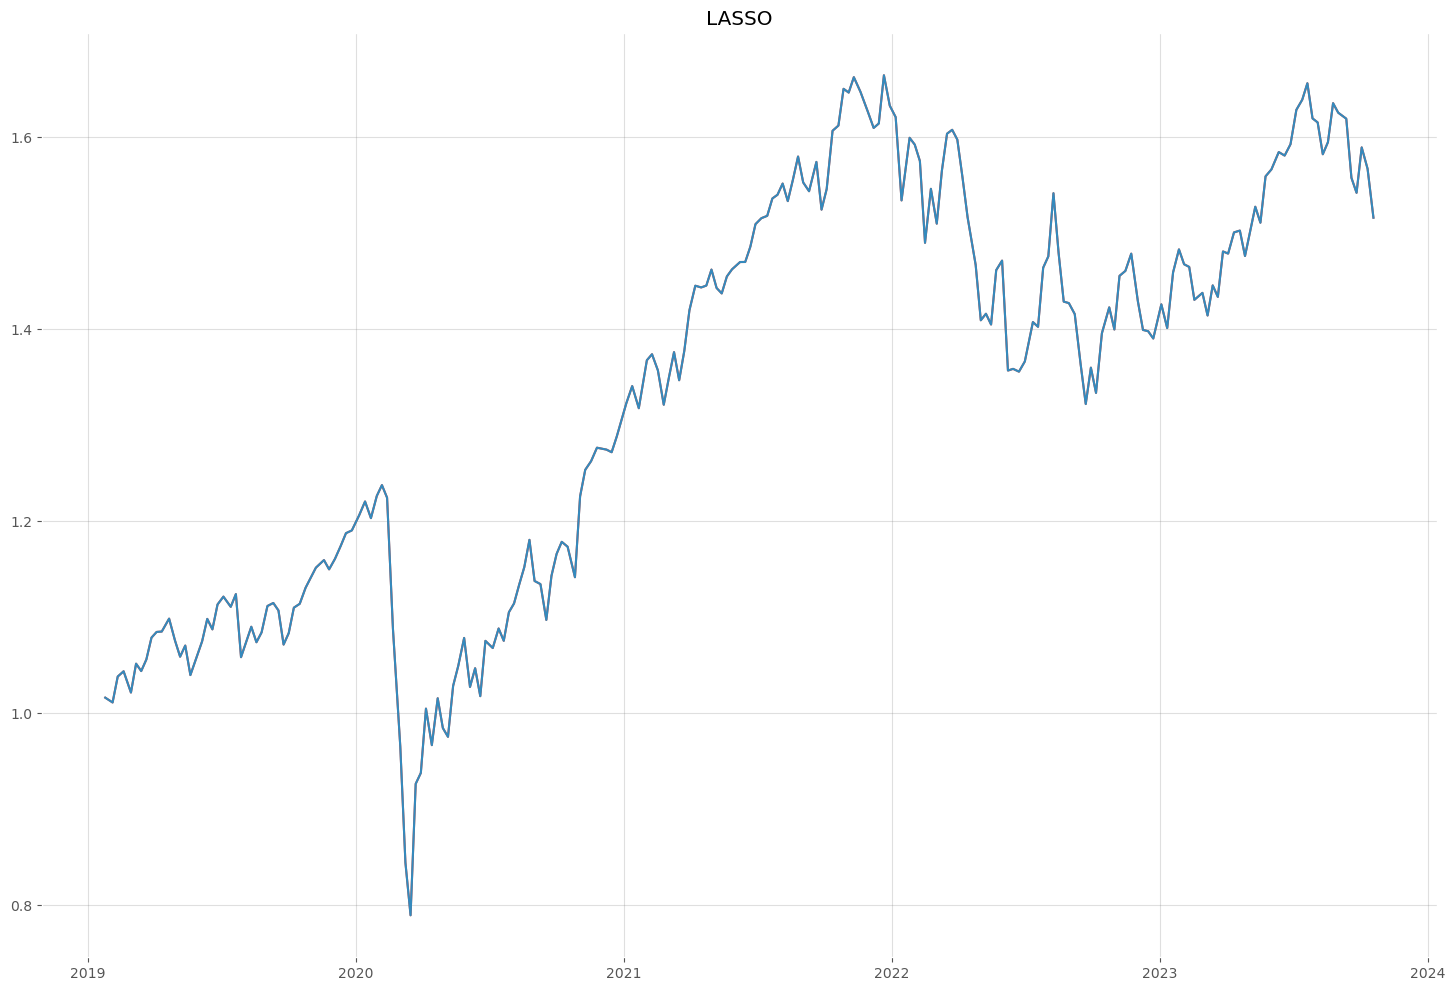

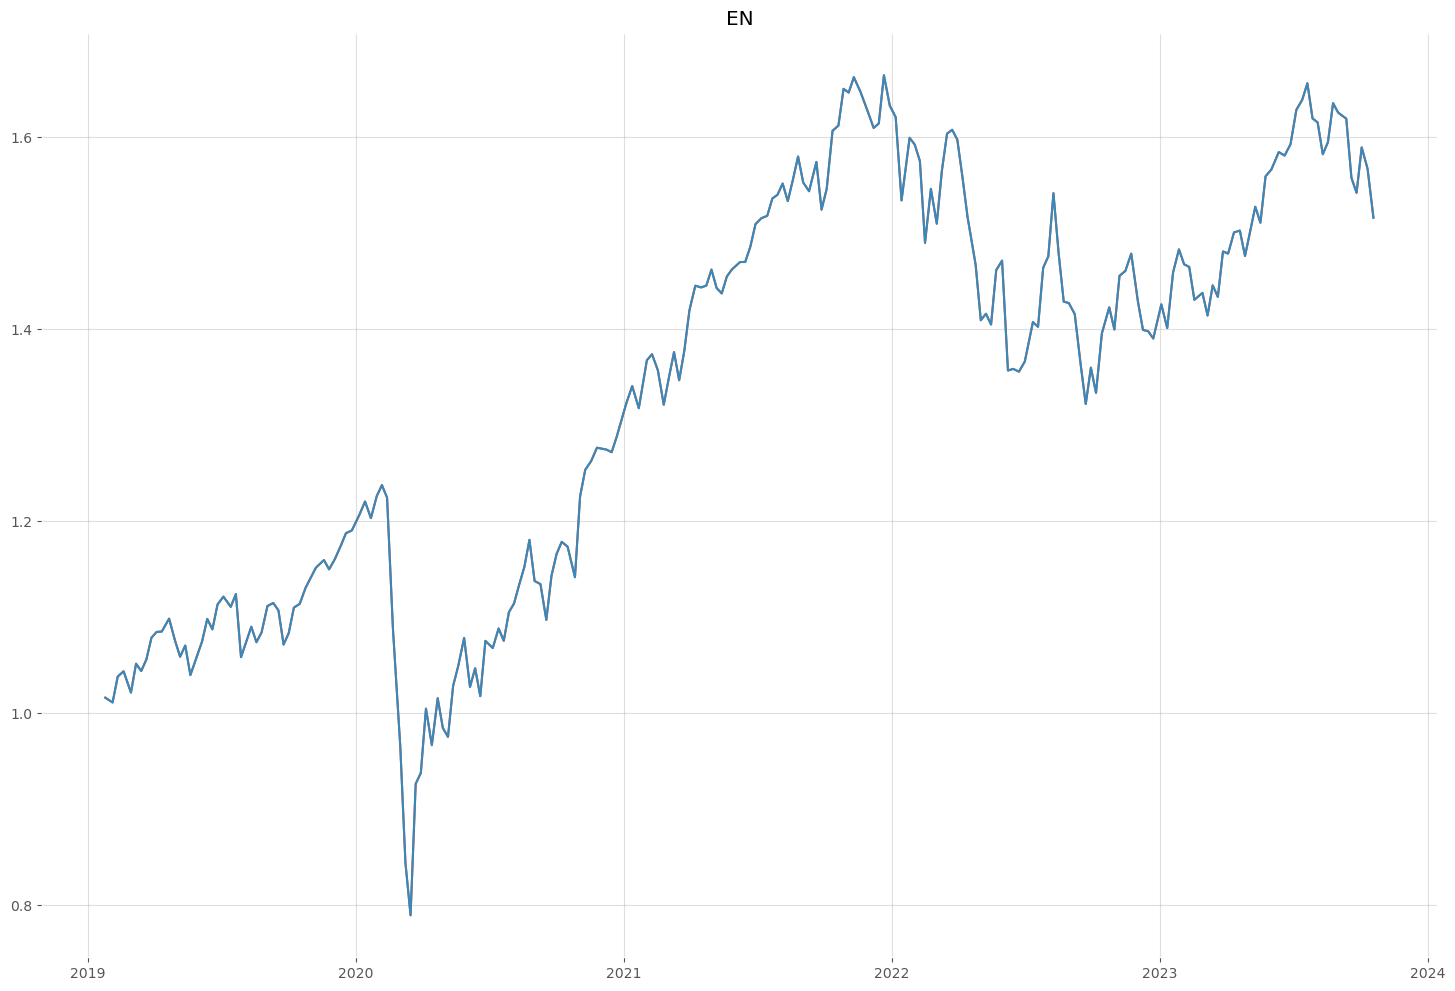

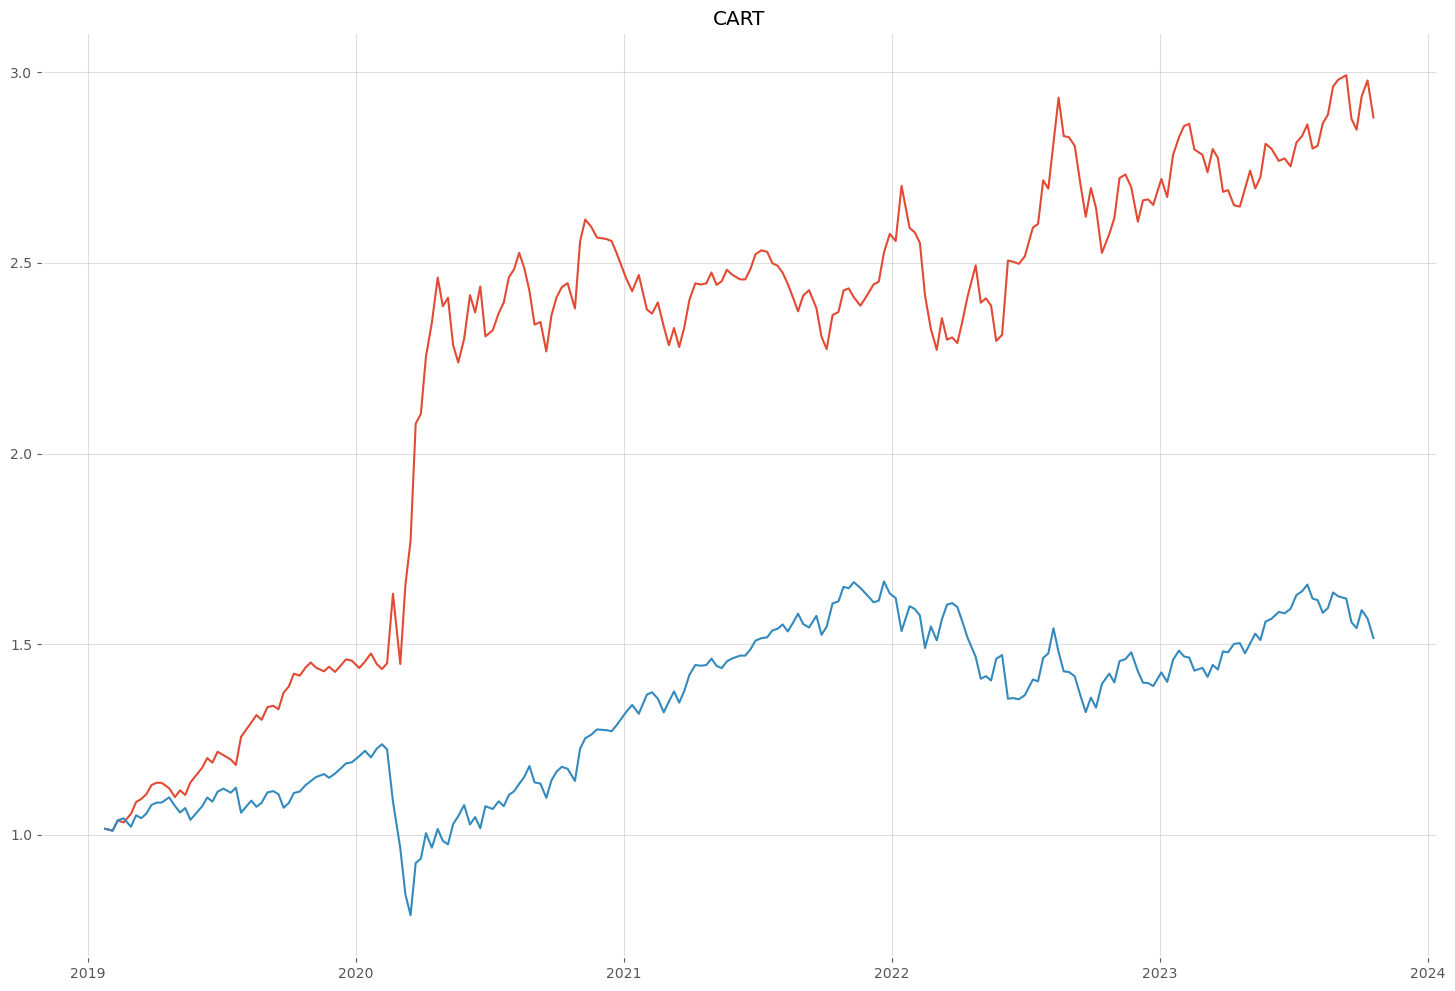

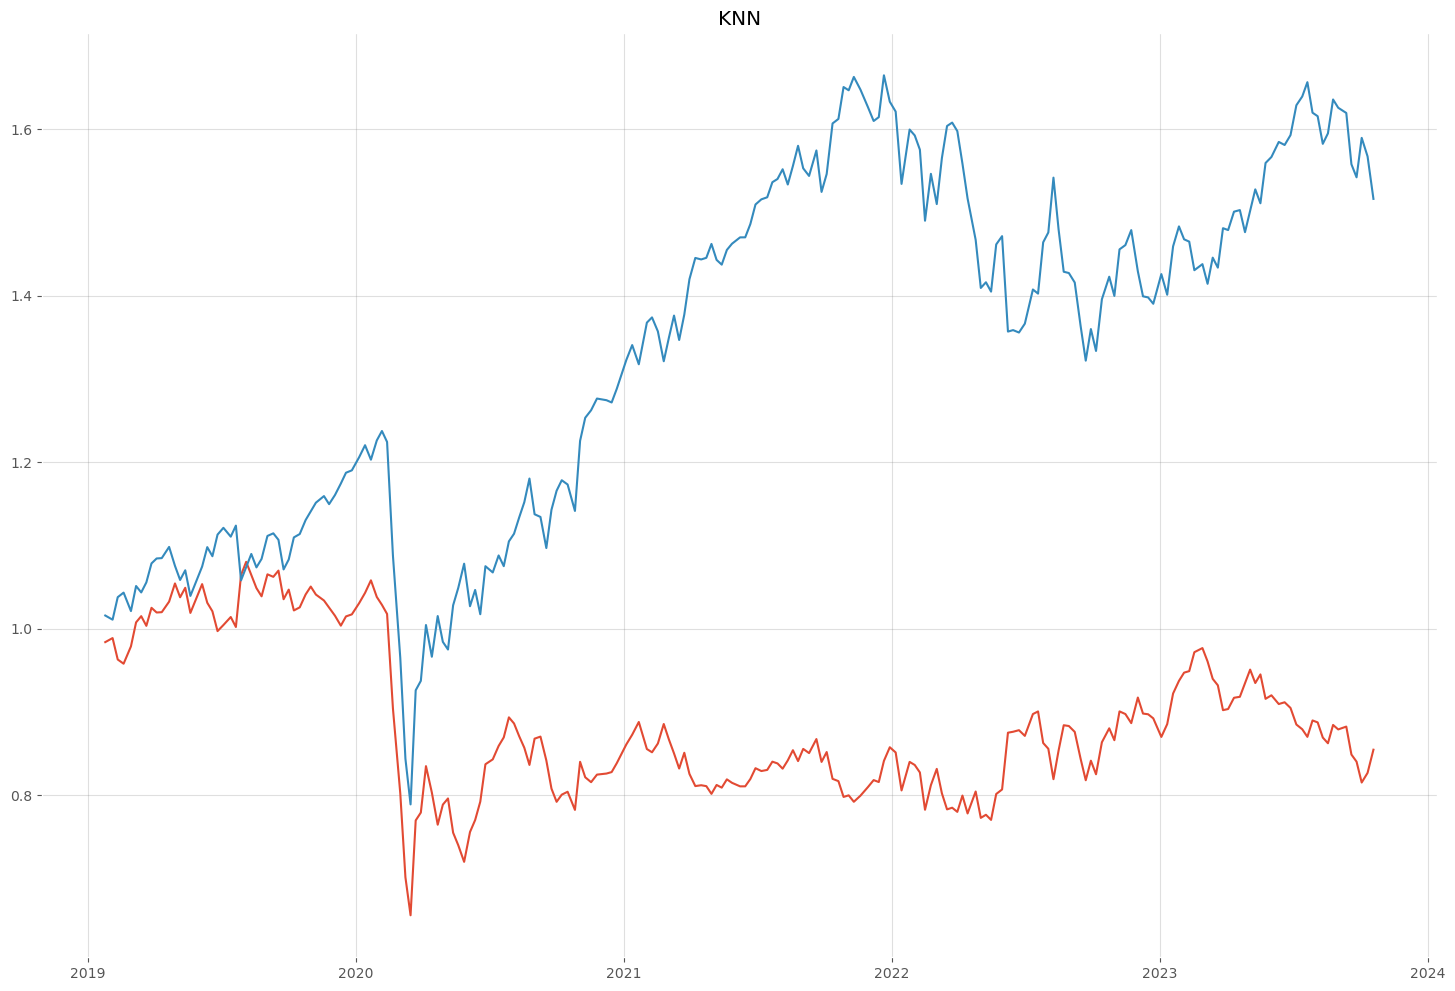

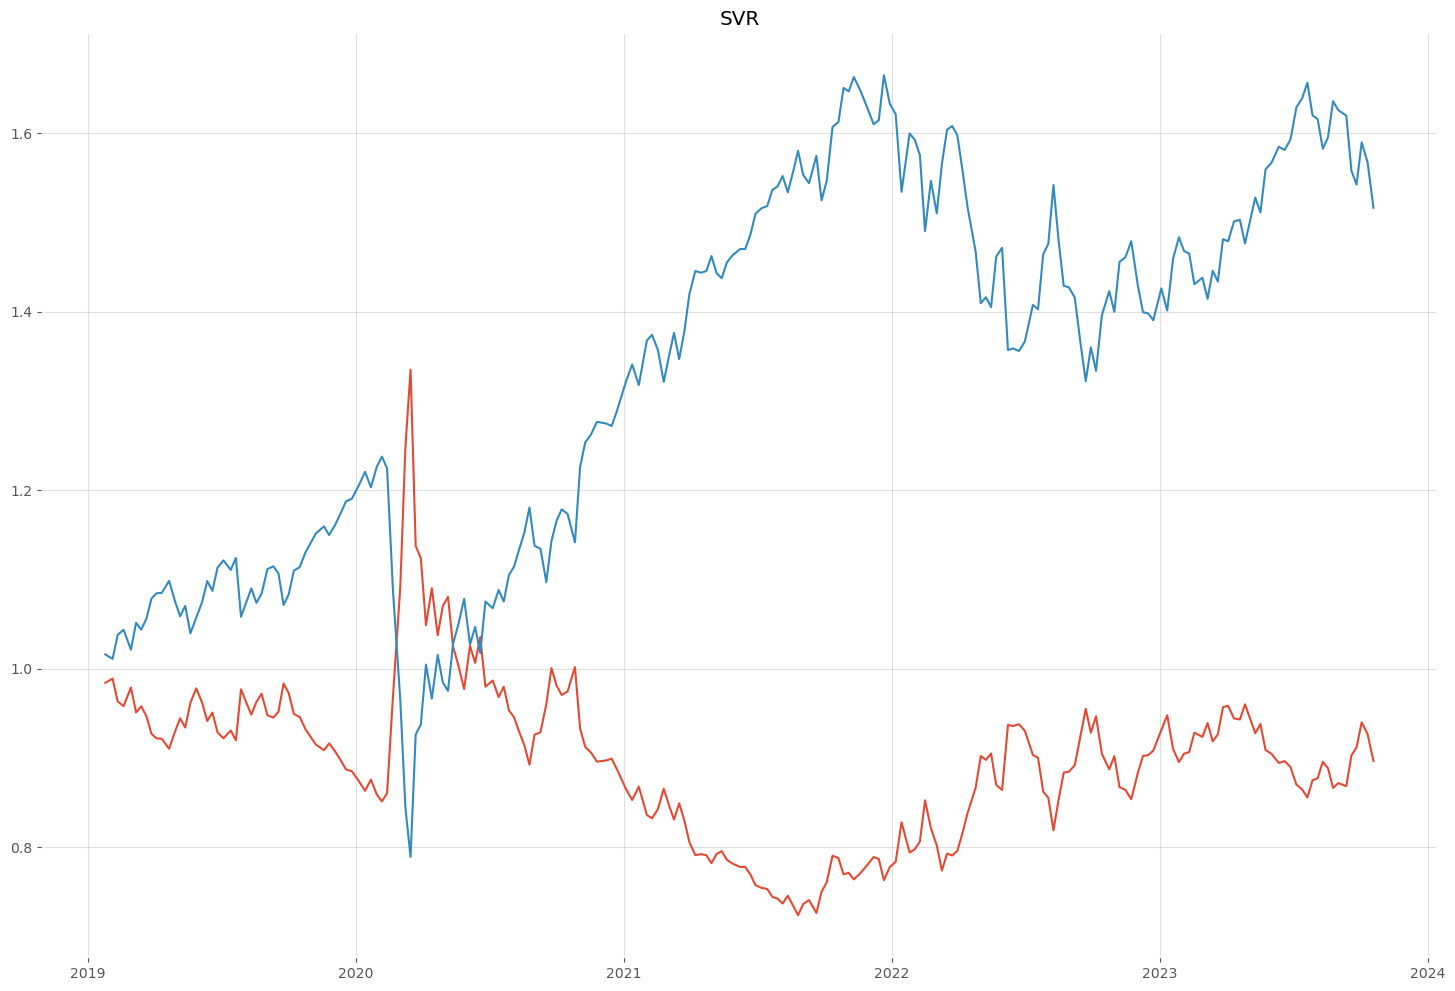

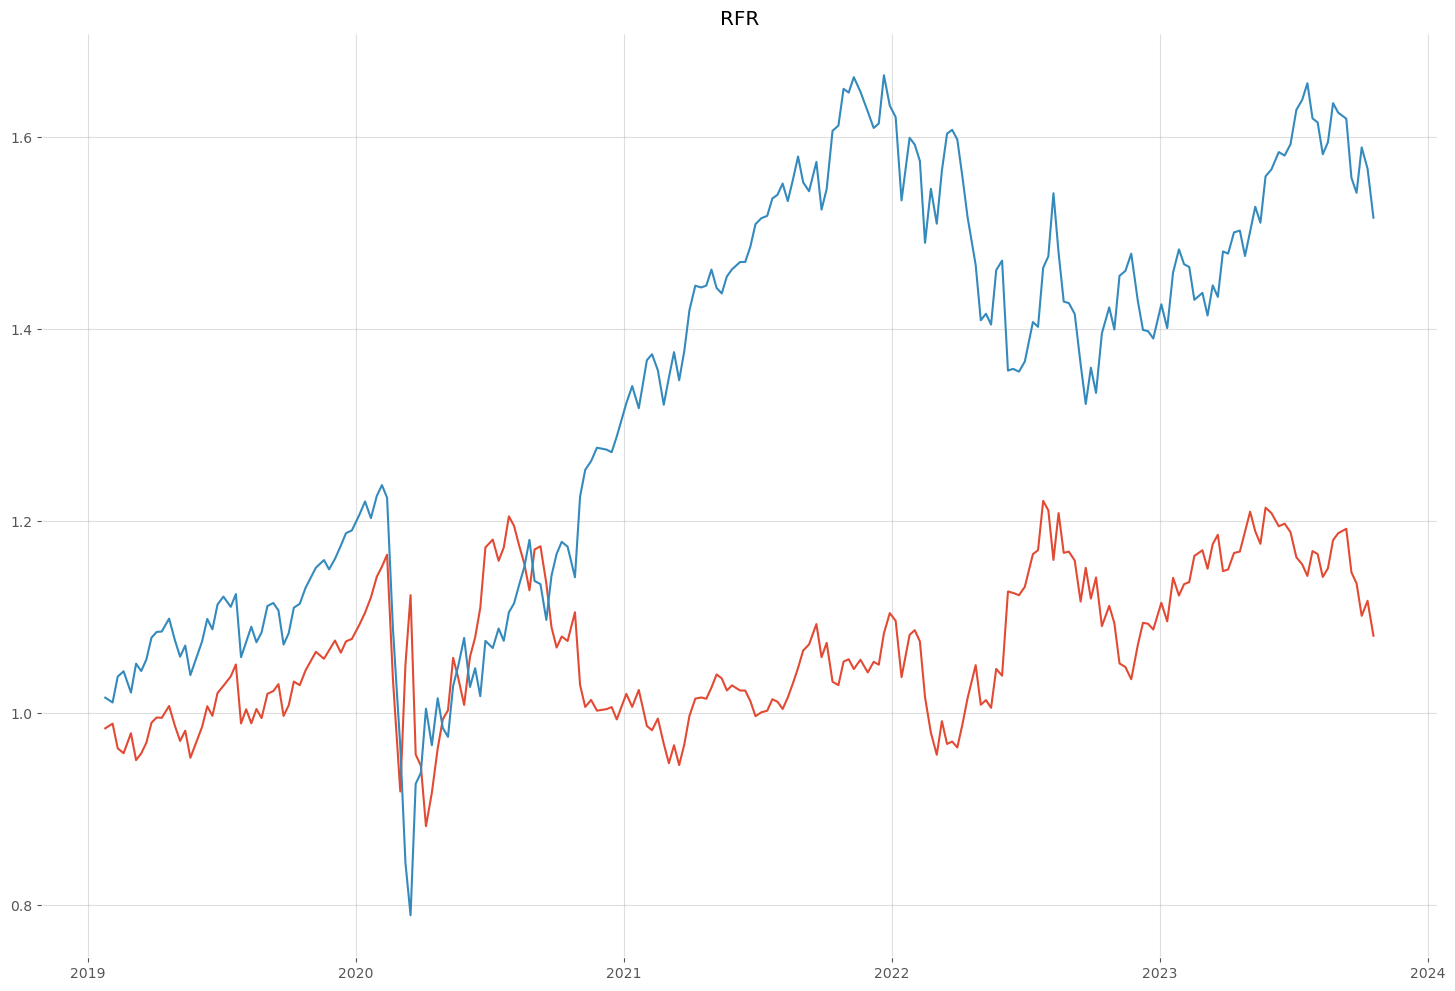

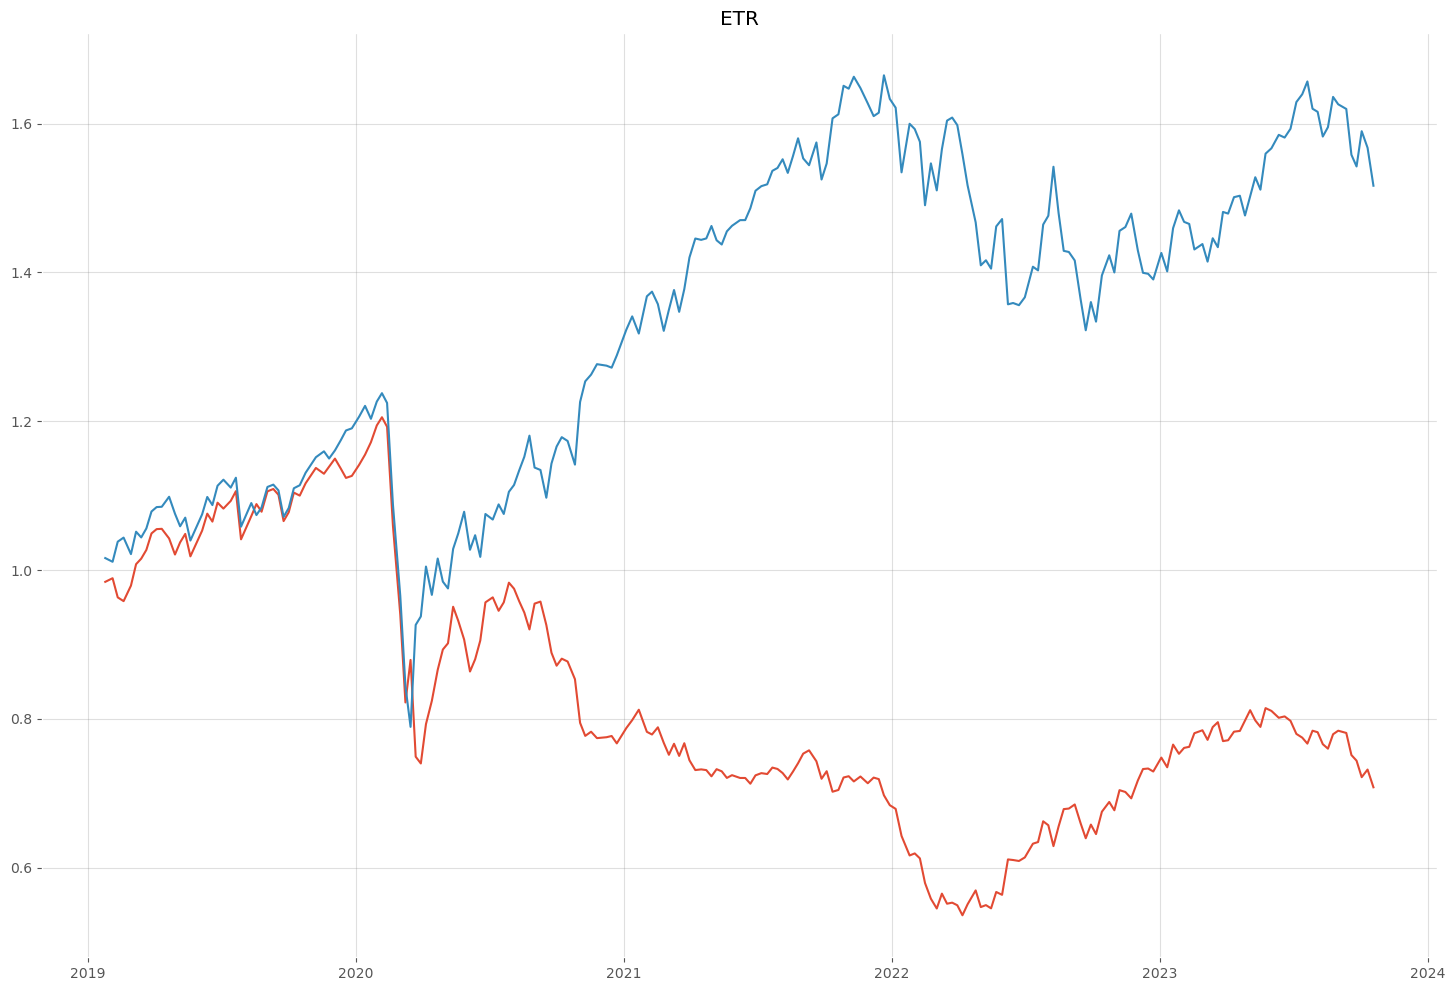

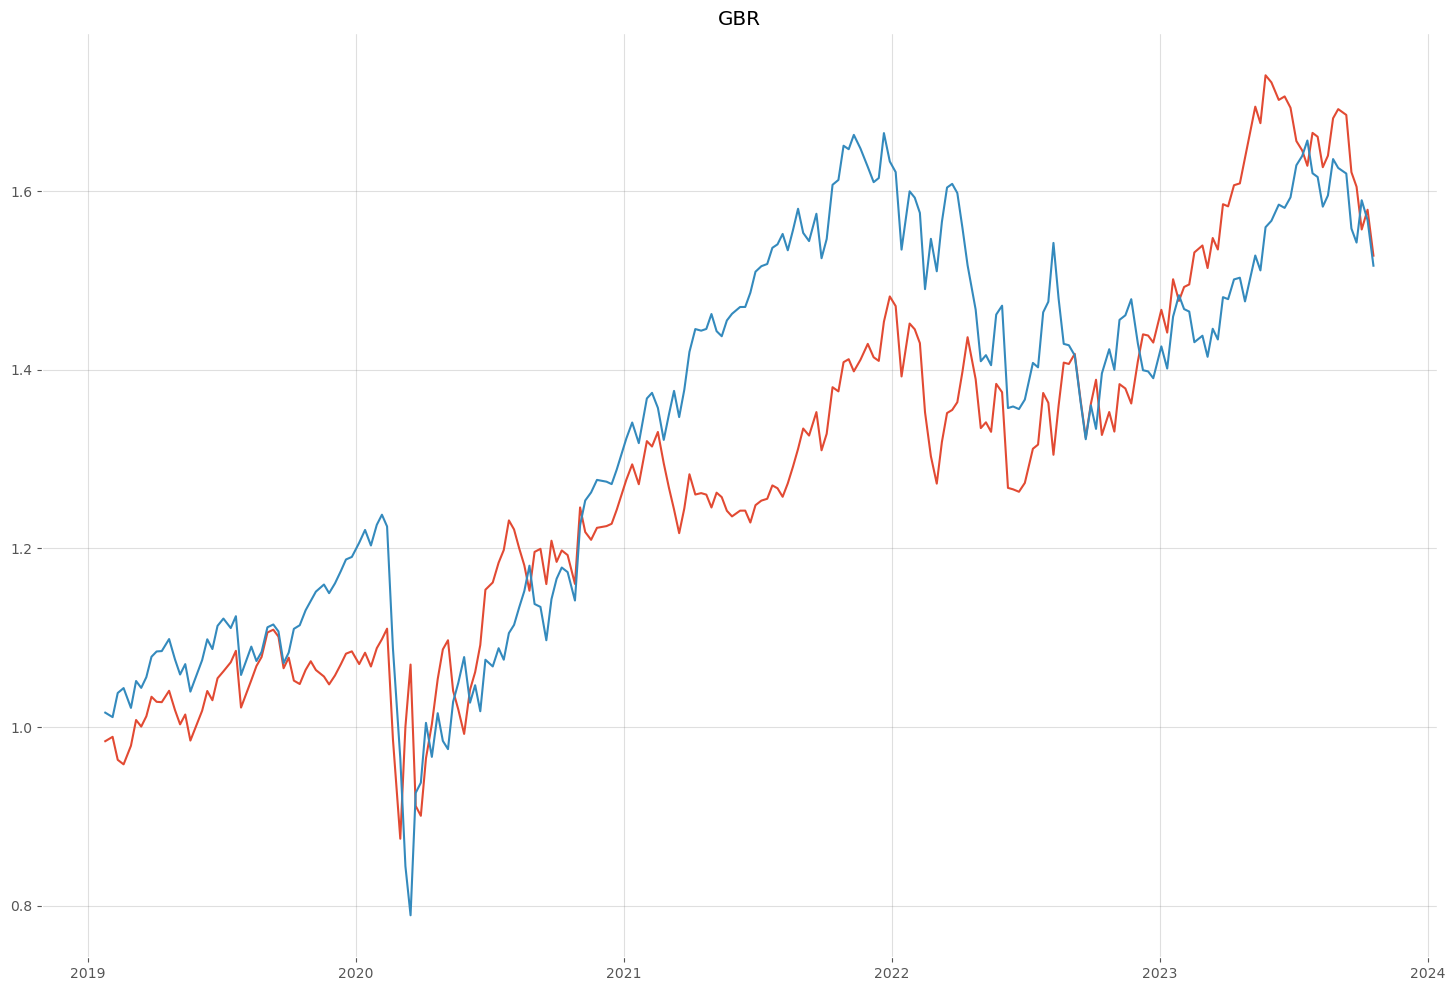

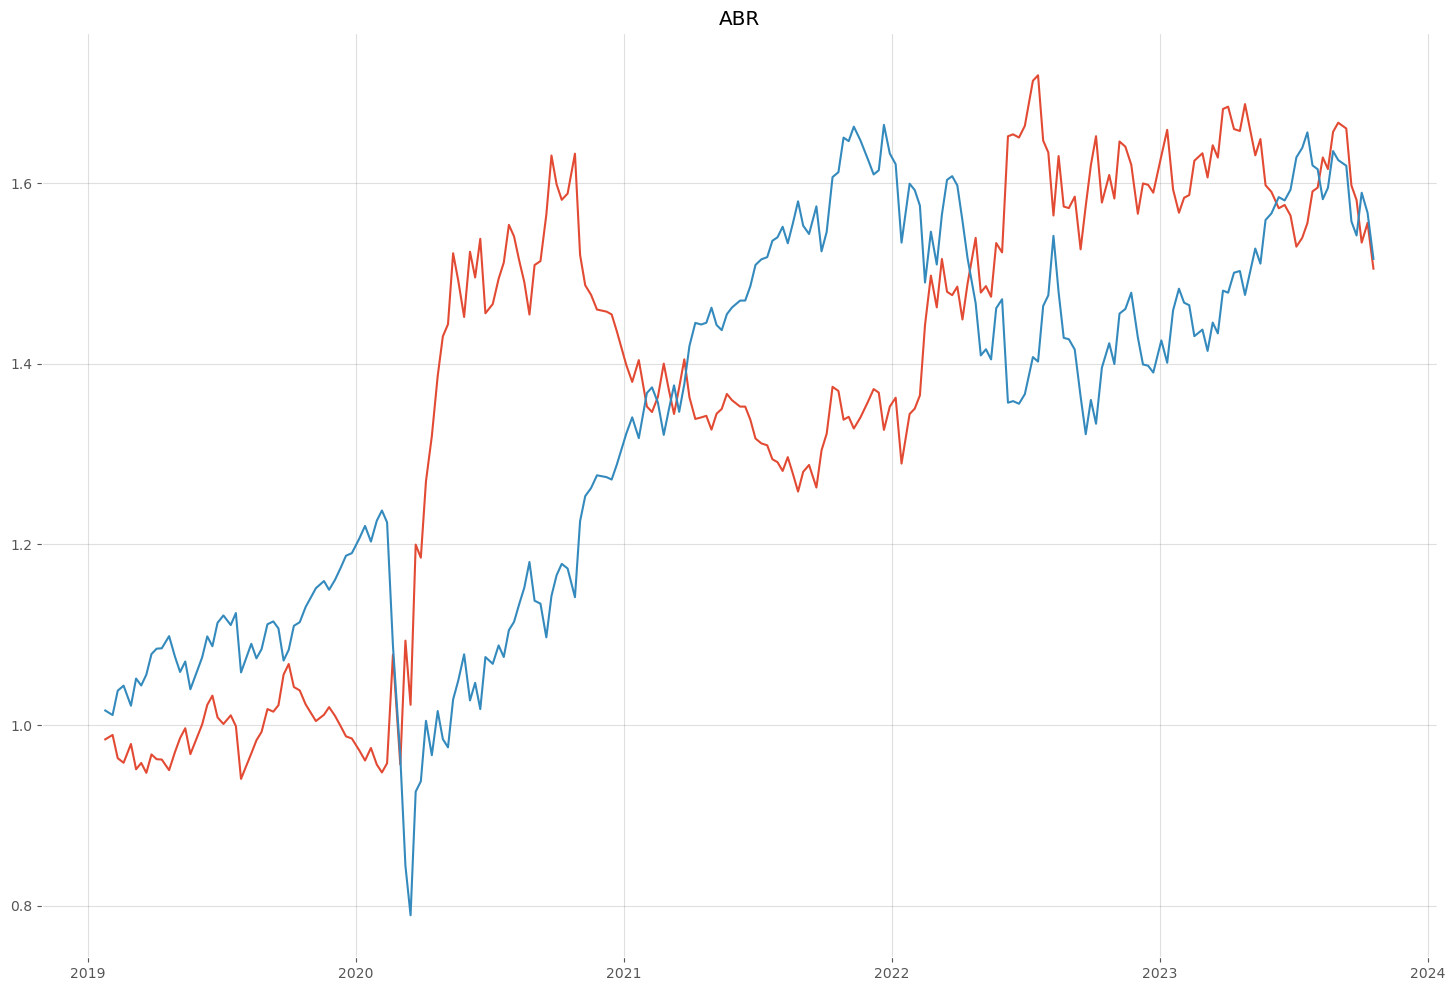

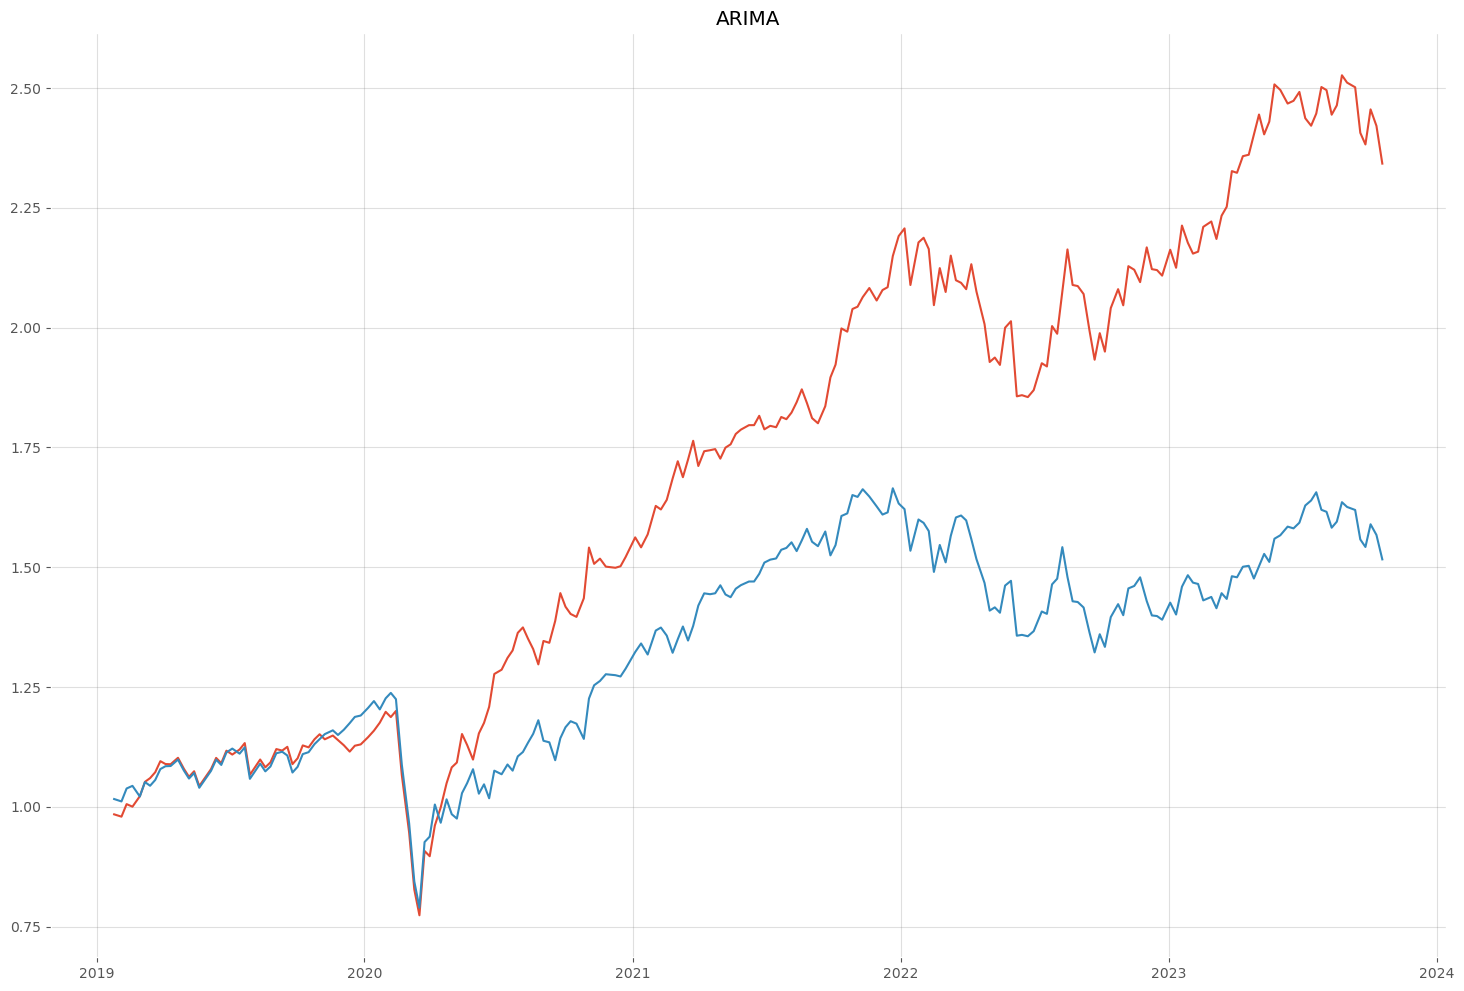

In [36]:
test_df1 = test_df.copy()
initial_capital = 1e5

for name in test_df1.columns:
    
    position = f"{name}_position"
    strategy = f"{name}_strategy"
    capital = f"{name}_capital"
    cumulative = f"{name}_cumulative"
    performance = f"{name}_performance"
    drawdown = f"{name}_drawdown"
    sharpe = f"{name}_sharpe"
    cagr = f"{name}_cagr"
    
    #Strategy Returns
    test_df1[position] = 0
    test_df1[position] = np.sign(test_df1[name])
    
    test_df1[strategy] = 0
    test_df1[strategy] = SPY_log['SPY_pred'] * test_df1[position]
    
    #Sharpe
    sharpe = np.sqrt(253) * (test_df1[strategy].mean()/test_df1[strategy].std())
    
    #Capital
    test_df1[capital] = initial_capital
    for i in range(len(test_df1)):
        test_df1[capital][i] = \
        test_df1[capital][i-1] * (test_df1[strategy].apply(np.exp)[i])
    
    #CAGR
    days = (test_df1.index[-1] - test_df1.index[0]).days
    cagr = ((((test_df1[capital][-1]) / (test_df1[capital][0]))**(365.0/days))- 1)
    
    
    #Maximum drawdown
    window = 253
    rolling_max = test_df1[capital].rolling(window = window, min_periods = 1).max()
    daily_drawdown = test_df1[capital] / rolling_max - 1.0
    max_daily_drawdown = daily_drawdown.rolling(window = window, min_periods = 1).min()
    
    #Plotting graph
    test_df1[cumulative] = test_df1[capital]/initial_capital
    metrics = f"{name}| Capital: %s Sharpe: %.3f CAGR: %.3f Max_DD: %.3f" % (test_df1[capital][-1], sharpe, cagr, max_daily_drawdown.min())
    print(metrics)
    plt.figure(figsize=(18,12))
    plt.title(name)
    plt.plot(test_df1.index, test_df1[cumulative])
    plt.plot(SPY_log['SPY_pred'].cumsum().apply(np.exp))  

### <a id = "smmacd"> </a> <font color = "green"> SM + MACD </font>  [back to table of contents](#top) / [Strategy](#p1.4.2)

After trading, 801910.38642684 amount of money left.
Sharpe Ratio is 0.569126845095537
Compound Annual Growth Rate (CAGR) is 0.11576273151344663
Max drawdown is 0.2494479648419911


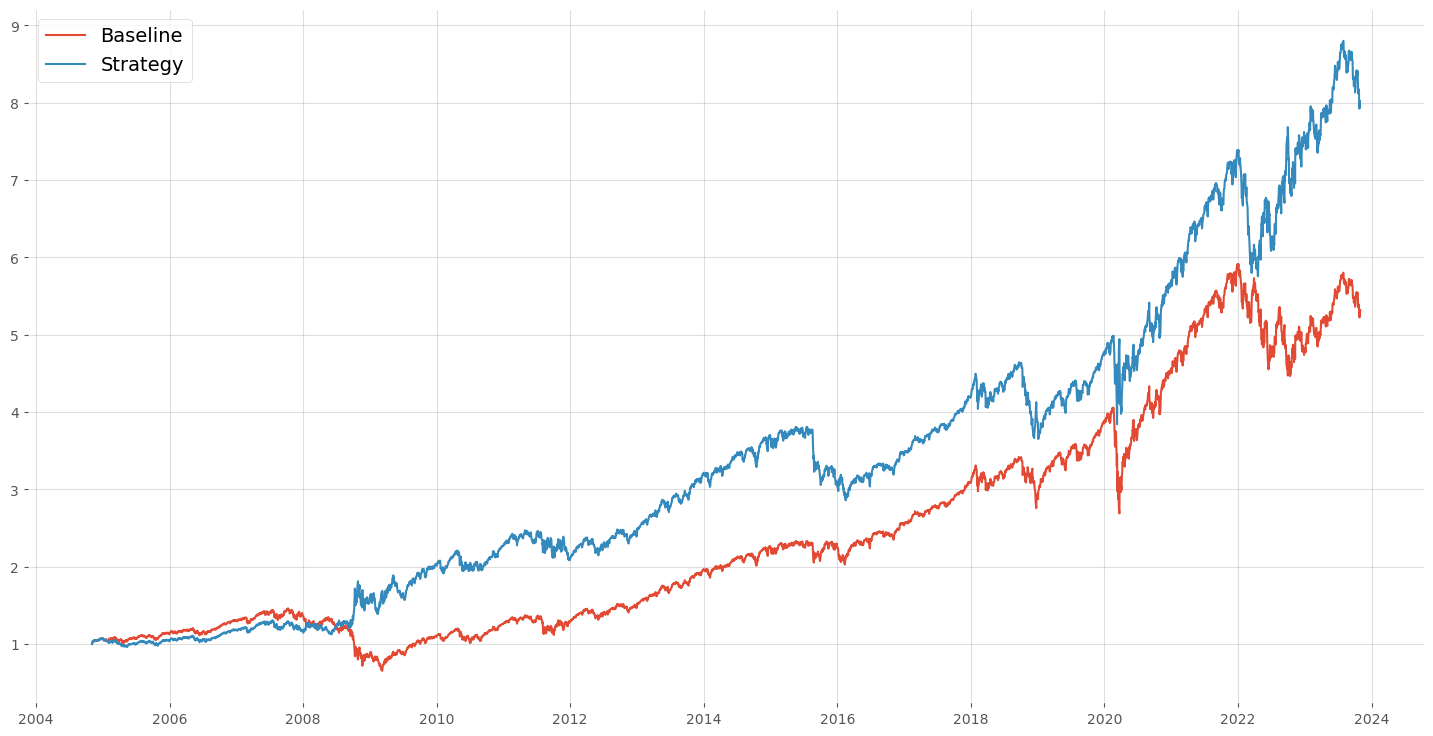

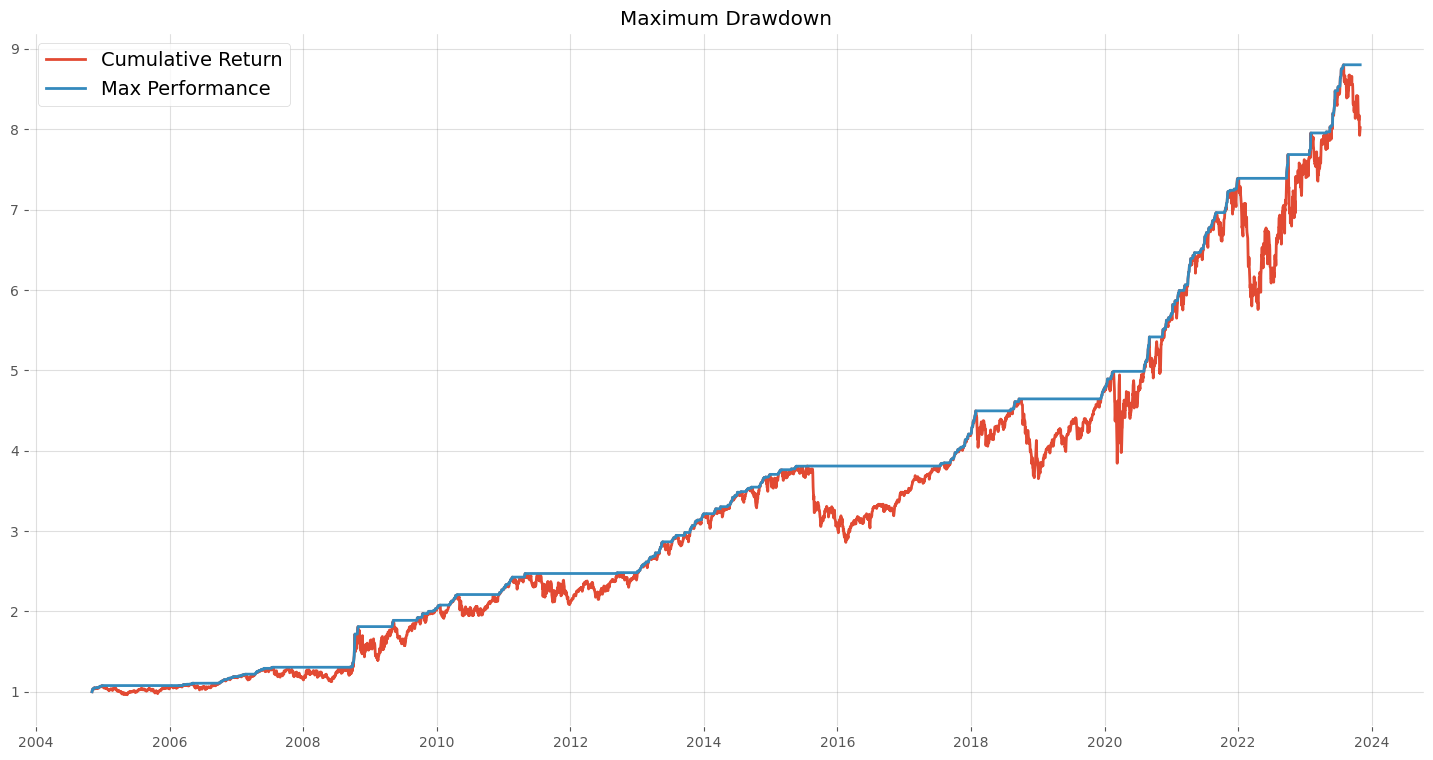

In [131]:
df_strategy_SM_MACD = df_strategy
df_strategy_SM_MACD["position"] = set_SM_MACD_position(df_strategy_SML_MACD, 10, 200, 20, 30, 5)
df_strategy_SM_MACD[['str_return', 'cul_return']] = cal_str_cul_return(df_strategy_SM_MACD)[['str_return', 'cul_return']]
backtesting(df_strategy_SM_MACD, capital)

### <a id = "somics"> </a> <font color = "green"> Stochastic Oscillator + Momentum Indicator Crossover Strategy </font>  [back to table of contents](#top) / [Strategy](#p1.4.3)

After trading, 766495.7703910785 amount of money left.
Sharpe Ratio is 0.657321181281571
Compound Annual Growth Rate (CAGR) is 0.11311420161495955
Max drawdown is 0.3897897709250199


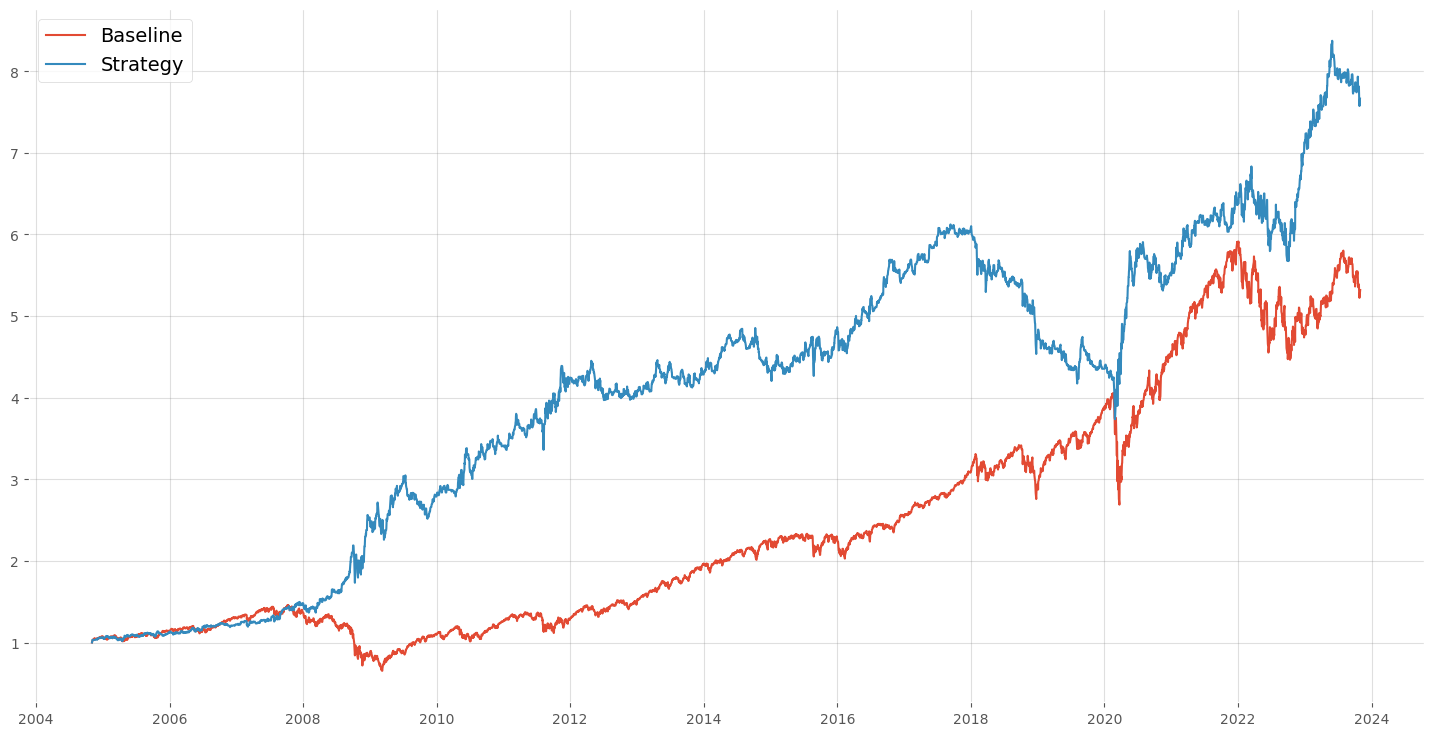

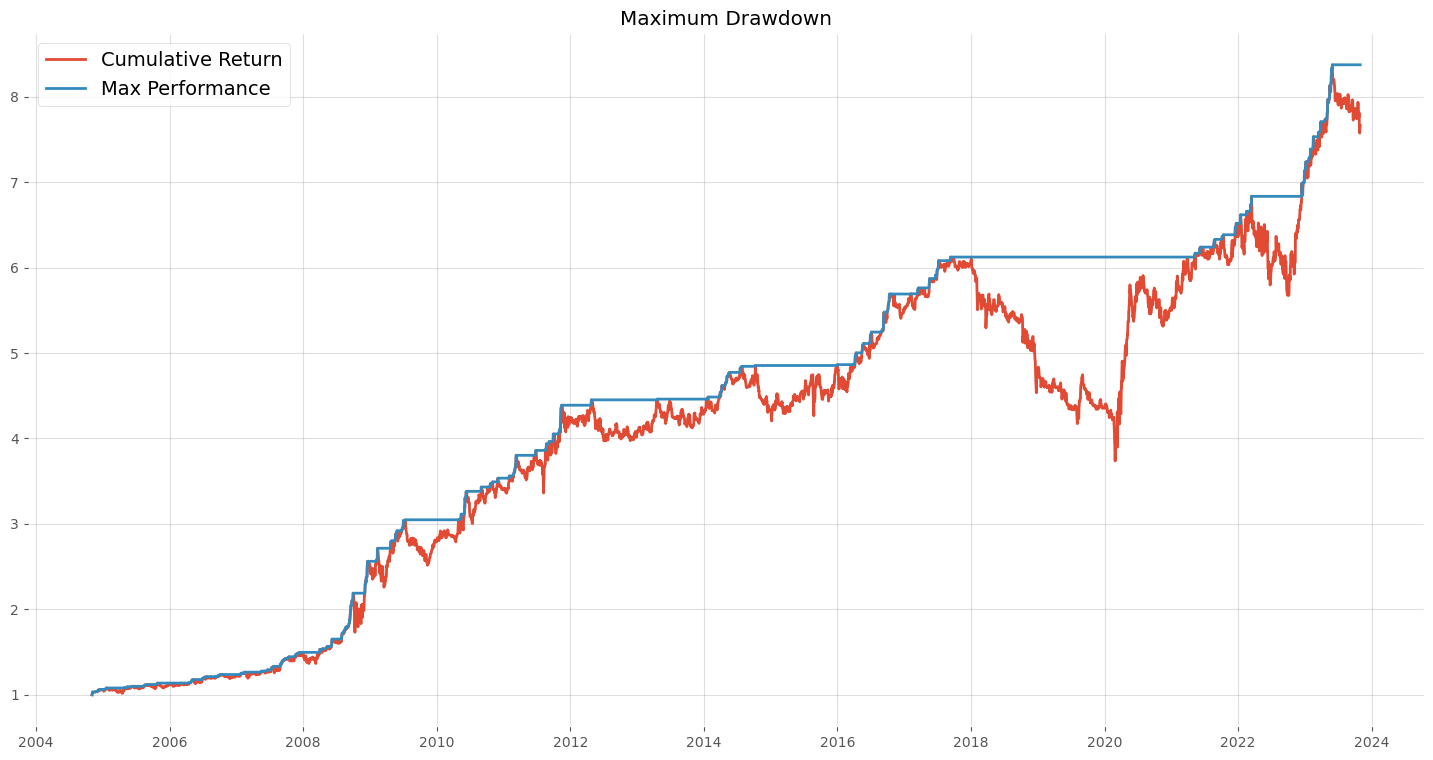

,Adj Close,SO_position,MICS_position,position,str_return,cul_return,Max_performance,Drawdown
Date,,,,,,,,
2004-11-01,78.617897,-1,-1,1,NaN,NaN,NaN,NaN
2004-11-02,78.645660,-1,-1,1,0.000353,1.000353,1.000353,-0.000000
2004-11-03,79.636040,-1,-1,1,0.012514,1.012951,1.012951,-0.000000
2004-11-04,80.723465,-1,-1,1,0.013563,1.026782,1.026782,-0.000000
2004-11-05,81.229065,-1,-1,1,0.006244,1.033213,1.033213,-0.000000
...,...,...,...,...,...,...,...,...
2023-10-24,423.630005,-1,-1,1,0.007511,7.813244,8.373904,0.066953
2023-10-25,417.549988,-1,-1,1,-0.014456,7.701107,8.373904,0.080345
2023-10-26,412.549988,-1,-1,1,-0.012047,7.608889,8.373904,0.091357


In [189]:
df_strategy = pd.DataFrame(spy['Adj Close'])
df_strategy_SO_MICS = df_strategy
df_strategy["SO_position"] = set_SO_position(df_strategy, 10, 6)
df_strategy["MICS_position"] = set_MICS_position(df_strategy,5, 0.065, -0.1)
df_strategy["position"] = -np.where(df_strategy["SO_position"]==df_strategy["MICS_position"], df_strategy["SO_position"],0)
df_strategy_SO_MICS[['str_return', 'cul_return']] = cal_str_cul_return(df_strategy_SO_MICS)[['str_return', 'cul_return']]
backtesting(df_strategy_SO_MICS, capital)
df_strategy_SO_MICS

# <a id = "p3"> </a> <font color = "green"> PART3 EXECUTIVE SUMMARY </font>  [back to table of contents](#top)

### Momentum Strategy

##### The SMA is the simplest moving average to create. It simply represents the average price throughout the selected time period. The average is referred to as "moving" because it is plotted bar by bar on the chart, generating a line that travels along the chart as the average value changes. SMAs are frequently used to predict trend direction.

Short: 151 days, Long: 152 days \
There is currently USD 776,365.74 in our account, a significant surplus of about USD 240,000 over our benchmark total return. The calculated Sharpe ratio and Compound Annual Growth Rate (CAGR) are 0.5603 and 0.1139, respectively, which are both slightly higher than the benchmark. Furthermore, the maximum drawdown of 0.3372 is significantly lower than the benchmark, confirming the strategy's outperformance. To summarise, our method outperformed the benchmark across multiple parameters, demonstrating its effectiveness in generating profits.

##### Exponential Moving Average (EMA) and Simple Moving Average (SMA) both measure trend direction over time. However, whereas SMA simply computes an average of price data, EMA gives more weight to more recent data.

Short: 175 days, Long: 278 days \
The performance measures show an excellent financial position, with an account balance of USD 692,433.68, representing a USD 160,000 surplus over the benchmark. While the calculated Sharpe ratio of 0.5291 is slightly lower than the benchmark, it indicates a good risk-adjusted return. The Compound Annual Growth Rate (CAGR) of 0.1071 indicates a consistent growth rate that is somewhat higher than the benchmark. Furthermore, the maximum drawdown of 0.4225 indicates a lower risk exposure than the benchmark, implying a more resilient performance during market downturns.

### Mean Reversion

We could not found a mean reversion strategy that can beat the market. Here is the reason why: 

Due to a variety of issues, mean-reversion strategies confront difficulties in continuously outperforming the market. Markets frequently exhibit long-term trends that defy the notion of a steady mean, reducing the efficacy of mean-reversion strategies. The high transaction expenses that come with frequent trading might eat away at potential gains. Furthermore, mean-reversion models may have difficulty adapting to shifting market dynamics and regimes. Behavioural factors, such as irrational investor behaviour and sentiment, can cause prices to deviate from historical averages over long periods of time. Overshooting risks, a lack of fundamental explanation, and an inability to evaluate broader market forces all contribute to mean-reversion methods' weaknesses. While they may have moments of success, combining a diverse approach that takes into account both technical and fundamental elements is critical for navigating the market's intricacies.

### Machine Learning

When taking into consideration Machine Learning algorithms, here are the top 3 strategies:
1. Linear Regression
2. CART
3. ARIMA

##### Linear regression can be quickly broken down as obtaining a best-fit line for predicted Y variables from an input of multiple X independent variables, each with a coefficient representing the weight of the independent variables' impact on the Y dependent variable. The algorithm searches for the optimal fit after providing input features (X), and future Y variables are predicted from this best-fit line. From this, we obtained the below performance metrics:

Cumulative return: 2.34x vs 1.52x

Sharpe: 2.047 vs 0.995

CAGR: 0.201 vs 0.088

Max drawdown: -0.401 vs -0.355

##### The CART algorithm can be quickly broken down as a decision tree algorithm, which makes decisions based on rules set by the data features input into the algorithm. The algorithm then arrives at a final leaf node, which can be seen as a prediction of the direction and magnitude of returns. From this, we obtained the below performance metrics:

Cumulative return: 2.73x vs 1.52x

Sharpe: 2.425 vs 0.995

CAGR: 0.232 vs 0.088

Max drawdown: -0.212 vs - 0.355

##### ARIMA is a simple time series forecasting method that models: 

#### AR - the correlation between a variable and its previous values

##### MA - the correlation between an observation and a residual error from a moving average model.

##### From this, we obtained the below performance metrics:

Cumulative return: 2.34x vs 1.52x

Sharpe: 2.047 vs 0.995

CAGR: 0.201 vs 0.088

Max drawdown: -0.401 vs -0.355

##### (ARIMA seems to have identical performance metrics when compared against Linear Regression. We believe this is due to the order of ARIMA chosen (2, 0, 0))

##### We observe that the Machine learning strategies are not comparable to the momentum & mean reversion strategies, as they are backtested over different periods and not over the same timeframe.  

### Combined Strategy

#### SM + MACD

A balance of USD 801,910.39 remains after trading, indicating that the SMA + MACD method was successfully implemented. The Sharpe Ratio of 0.5691 indicates a good risk-adjusted return, showing that the strategy outperformed expectations for the level of risk taken. The Compound Annual Growth Rate (CAGR) of 0.1158 demonstrates the strategy's potential to provide consistent profits over time.

The SMA (Simple Moving Average) + MACD (Moving Average Convergence Divergence) method is notable for its expert mix of trend-following (MACD) and mean-reverting (SMA) features. The MACD recognises and capitalises on trends, allowing the approach to effectively ride upward or downward moves. Simultaneously, the SMA incorporates mean-reversion features, allowing it to adjust to changing market conditions.

This combination allows the approach to navigate several market regimes, capturing trends while limiting risk during potential reversals. The strategy's performance is further demonstrated by the strategy's moderate maximum drawdown of 0.2494, which demonstrates its resilience in handling downside risk.

In essence, the capacity of the SMA + MACD strategy to integrate trend-following and mean-reverting features contributes to its effectiveness, allowing it to outperform the market by capitalising on both rising trends and mean-reverting opportunities.


#### Stochastic Oscillator + Momentum Indicator Crossover Strategy

The remaining balance of $766,495.77 after trading demonstrates the success of the Stochastic Oscillator + Momentum Indicator Crossover Strategy. The strategy's remarkable Sharpe Ratio of 0.6573 suggests a strong risk-adjusted return, indicating its capacity to deliver considerable gains relative to the associated risk. The Compound Annual Growth Rate (CAGR) of 0.1131 represents a stable annual growth rate, emphasising the strategy's long-term performance.

The capacity of the approach to handle downside risk, as indicated by the maximum drawdown of 0.3898, adds to its success. The Stochastic Oscillator detects probable reversal points, whilst the Momentum Indicator aids in the detection of significant directional moves. The crossover of these two indicators most likely improves the strategy's capacity to detect appropriate market entry and exit moments.

The Stochastic Oscillator and Momentum Indicator work together to give a balanced approach by including both trend-following and momentum-driven aspects. This enables the approach to traverse through a variety of market circumstances, capturing trends while limiting risks during potential reversals.

In conclusion, the Stochastic Oscillator + Momentum Indicator Crossover Strategy illustrates its usefulness by providing a high risk-adjusted return, constant annual growth, and good risk management. The strategy's ability to capitalise on both momentum and reversal opportunities helps it beat the market overall.

#### Stochastic Oscillator
The Stochastic Oscillator is a popular mean-reversion indicator used in technical analysis to determine potential overbought or oversold conditions of an asset's price. It compares a security's closing price to its price range over a specified period of time.

%K Line Calculation:

%K = (Current Close Price - Lowest Low) / (Highest High - Lowest Low) * 100 Current Close Price: The most recent closing price. Lowest Low: The lowest price observed over a defined period. Highest High: The highest price observed over the same defined period. %D Line Calculation:

%D is a moving average of %K. It's typically a 3-period simple moving average (SMA) of %K. The Stochastic Oscillator produces values ranging from 0 to 100. The indicator fluctuates between these extremes to identify potential areas where the price might be overbought (above 80) or oversold (below 20). Traders often look for signals generated by crossovers, divergences, or extreme readings to make trading decisions:

Overbought Signals (Sell): When the indicator rises above 80, it suggests the price may be overbought, and there might be a potential reversal or a pullback in the price. Traders might consider selling or reducing long positions.

Oversold Signals (Buy): When the indicator falls below 20, it suggests the price may be oversold, indicating a potential upward reversal. Traders might consider buying or taking long positions.

# <a id = "p4"> </a> <font color = "green"> PART4 SELF-CRITIQUE </font>  [back to table of contents](#top)

### Momentum Strategy

#### SMA

The durations chosen for the short and long periods of the simple moving average are an important consideration in evaluating the approach. The difference of only one day between these periods raises questions about the practicality and usefulness of the criteria adopted. In a volatile market, such a fine distinction may not capture relevant patterns or provide a solid platform for decision-making. It is critical to examine and possibly prolong the time span differentials to ensure a more comprehensive study, hence improving the strategy's adaptability and response to market volatility. Finding the right balance in identifying these periods will help to create a more solid and dependable framework for directing investment decisions.

#### EMA

We tried to balance responsiveness and trend identification by using an EMA (Exponential Moving Average) technique with a short period of 175 days and a long duration of 278 days. However, we admit that the timeframes chosen may not effectively capture short-term variations or long-term patterns. A potential refinement would be to reassess market conditions in order to fine-tune these durations for greater adaptability. Furthermore, periodic appraisal of the strategy's performance in light of changing market dynamics is critical. This self-critique emphasises the significance of ongoing evaluation and change in order to optimise the EMA strategy for changing market conditions.

### Machine Learning

#### Table of contents:
1. Summary of SPY ETF
2. Feature selection
3. Performance metrics
4. Hyperparameter tuning
5. Establishing positions & trading signals

##### Summary of SPY ETF
SPY can be understood as the barometer of the US economy. When broken down, the SPY is an ETF that tracks the S&P500 Index, which tracks the stock performance of the top 500 companies listed on stock exchanges in the USA. It is also a capitalization-weighted index and potentially brings bias in the index. As of 30 September 2023, the top nine stocks in the index make up 30% of the index.

#### Feature selection
Index - 10-year Treasury yield, Nasdaq-100 ETF, VIX Index

Currencies - USDJPY, EURUSD, GBPUSD, USDCAD

Lagged variable - SPY 30-day

##### 10Y Yield
We believe the 10Y yield is a relevant feature for prediction of SPY's price. Treasury yields are a relevant feature for prediction of the US economic health. A common indicator for the health of the US economy is the Treasury yield curve, and the main yield spread commonly looked at is the 2Y10Y. However for the purposes of simplifying our feature selection to avoid overfitting, we opted to only use the 10Y yield, as it has the most traded futures contract for Treasuries, while also striking a good balance between short & long term interest rates. 

##### Nasdaq-100 ETF
The Nasdaq-100 index is an index that tracks the performance of the top 100 non-financial companies listed on the Nasdaq Stock Exchange. It is also capitalization-weighted, following a similar tracking methodology as the SPY. Most stocks in the Nasdaq-100 Index are also make up the S&P500 Index. 

##### VIX Index
With the surge in number of traders & higher volume in the US stock exchanges, options have become a popular financial instrument for trading. VIX is calculated from the price of SPX call & put 30-day maturity options and is commonly seen as the "fear gauge" of the economy, as it reflects investors' sentiment regarding market volatility and risk over the next 30 days. When investors hedge tail-risk and puts are bought at large amounts, this pushes up the VIX. However, VIX emits mean-reversion tendencies, and can also be used as a market-reversal signal, serving as a good prediction.

##### Currencies
Japan, Europe, United Kingdom and Canada are the countries with the highest foreign investment in the US. This translates to investments in the companies in the S&P500, which enhances the performance of the S&P500 Index. The strength of the USD can also be included, however I believe that it is more relevant to measure specific currencies than taking a broad index such as the US Dollar Index (DXY) as it could be too broad.

##### SPY lagged variable of 30-days
We opted for the 30-day lagged SPY variable as we believe a 1-month lag is an appropriate duration for estimating weekly returns on SPY. This avoids any short-term noise, while also avoiding any trends in longer term lags. 

##### Variables not selected: Top stocks in the S&P Index as of present, Dow Jones Index
We choose to omit the current top stocks in the S&P500 index, as the training period for our machine learning models are from 2004 - 2019. During this period, companies such as AAPL, AMZN, GOOGL, META, TSLA etc., did not make up a big part of the index, as the index follows a capitalization-weighted approach.

The Dow Jones Industrial Average is an index that tracks the top 30 stocks listed on stock exchanges in the USA, and follows a price-weighted approach. This conflicts with the S&P500 index weighting methodology, while also containing significantly lesser companies that make up the index.

##### Performance metrics
From our performance metrics and understanding of machine learnings, we believe that the best model to use for our main strategy would the CART model.

Cumulative return: 2.73x vs 1.52x

Sharpe: 2.425 vs 0.995

CAGR: 0.232 vs 0.088

Max drawdown: -0.212 vs - 0.355

##### Hyperparameter Tuning
To ensure an optimal ARIMA model, we performed hyperparameter tuning and selected the ARIMA model order with the lowest residuals error. This gave us a result of (2, 0, 0)

##### Establishing positions & trading signals
While we were able to generate predicted log returns from the machine learning algorithms, we weren't able to immediately act upon the data. For simplicity, we opted to use only the algorithm's predicted direction, and exclude the magnitude of the prediction. Initially we tried to create positions based on whether the direction of prediction vs actual was the same, while also accounting for the error of the prediction vs the actual value. However, we realise that this makes the strategy unviable as forecasting for out of sample data would mean that we have no actual data used for measuring error.

### Combined Strategy

#### Overfitting or Coincidence:
Assuming that the opposite action would result in profits is based on the assumption that the strategy actions are consistently incorrect. However, it's essential to distinguish between a strategy's consistent mistakes and temporary market fluctuations. The opposite action might not always align with profitable market movements.

#### Market Dynamics: 
Markets can be unpredictable and often contrary. They might move against seemingly logical actions. What appears to be a losing position in the short term might sometimes turn profitable in the long run, and vice versa.

#### Risk of Chasing Losses: 
Reversing strategy solely because it's been losing money might lead to chasing losses or entering positions without a solid strategy. This can amplify losses if not approached carefully.




## <a id = "p5"> </a> <font color = "green"> Other: Contribution Statement </font>  [back to table of contents](#top)

For this project, the members of Group 3 collaborated wholeheartedly, participating in discussions for each section and every meeting.

CHEN ZHIYUAN: Mainly responsible for the mean-reversion part of the project, including MACD, RSI, etc. Although the initial strategy results were not ideal, through continuous discussions with another team member, optimized the strategy to achieve the best results. Actively participated in meetings.

DARREN CHAN YUK TSING: Primarily responsible for the machine learning part of the project, attempted to build machine learning models and achieved results. Continuously adjusted influencing factors and explored various parameter ranges to find the best machine learning approach. Actively discussed the writing approach for the report with team members, shared results, and provided constructive ideas for improving strategies. Analyzed results and actively contributed to discussions on other members' strategies.

WONG KEAT YE: Mainly responsible for the momentum part of the project, such as SM momentum strategy, EMA momentum strategy, and the final report writing and presentation. Facilitated organized discussions among team members, offered opinions and suggestions for each section, helped identify issues during code integration, optimized code, analyzed various indicators, and summarized work.

XUE YUANHUANG: Mainly responsible for combining different strategies and writing the foundational code. Developed refined and organized code structures for the report. Eagerly assisted all members and completed basic code for almost every strategy. Actively provided assistance when members encountered problems and completed the mean-reversion part of the code, such as Stochastic Oscillator and Commodity Channel Index, continuously optimizing to achieve the best combined strategy results.

YU CHUNXUE: Mainly responsible for building momentum strategies, such as SM momentum strategy, EMA momentum strategy, and combining strategies with other team members to obtain optimal strategy returns. Worked with team members to summarize the report and assist in addressing issues encountered during organization. Established the report framework. Actively discussed problems with team members and helped optimize strategy results.